### Anomaly Prediction usingSWaT_dataset_Jul 19 v2.xlsx (attack data is included in file)

In [ ]:
# Install required libraries 
!pip install -U kaleido
!pip install numpy
!pip install nb_black pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 13.6 MB/s 
     |████████████████████████████████| 1.5 MB 93.2 MB/s 
     |████████████████████████████████| 96 kB 3.2 MB/s 
     |████████████████████████████████| 843 kB 66.4 MB/s 
     |████████████████████████████████| 1.7 MB 65.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.3 MB 68.6 MB/s 
     |████████████████████████████████| 141 kB 78.1 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 
     |██████████

In [1]:
# If running from Google Colab, mount google drive to save generated artifacts
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# If running from Google Colab, mount google drive to save generated artifacts
# List contents on the mounted drive
# !ls "/content/drive/My Drive"

 01276521_195953.515.pdf
 2015CFALEVEL3TUESDAYS.pdf
'6242 Project document.gdoc'
'amalysis_30thJan spreadsheet.gsheet'
 analysis.gsheet
 c3finance_datamodel
'c3finance_datamodel (1)'
 c3finance_datamodel_credit.drawio
'CFA Level I II'
 ColabData
'Colab Notebooks'
'Copy of 529 Plan Comparison - Tax Deduction vs. Investment Fees.gsheet'
'Copy of 6242 Project document.gdoc'
'Copy of c3finance_datamodel.drawio'
'Copy of ISYE 6414 Lecture Transcripts.gdoc'
'Copy of  Summer21 DB - Grade Calculator.gsheet'
 Covid19SelfTestKit.pdf
'CRACKINGtheCODINGINTERVIEW6th (1).pdf'
 CRACKINGtheCODINGINTERVIEW6th.pdf
'Driving directions to 87 Southville Road, Southborough, MA.gmap'
 KumarKrishna.docx
'Kumon, Princeton.gmap'
'LeaseRenewalAgreement_4 21 2019.gdoc'
'LeaseRenewalAgreement_4 21 2019.pdf'
 Linear_Regression_Notes.docx
 OMSA6740-Fall2021-Xie-Syllabus.gdoc
 Picture
'Sr Data Scientist.docx'
 team041_p1_report.gdoc


In [ ]:
# Enable formatting
%load_ext nb_black

<IPython.core.display.Javascript object>

In [ ]:
from pycaret.anomaly import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import plotly.graph_objs as go
from datetime import datetime
import plotly.express as px
import os

<IPython.core.display.Javascript object>

## Methods to be used for plotting and summary statistics

In [ ]:
# Create a method which will set Attack ID and Actual Attack during attack period
# It will take a disctionary object in  format {"AttackID":["AttackStartTime", "AttackEndTime"]}
def setAttackActualData(df, attackDict):
    dfCopy = df.copy()
    for key, val in attackDict.items():
        dfCopy.loc[val[0] : val[1], "AttackID"] = key
        dfCopy.loc[val[0] : val[1], "Anomaly_Actual"] = 1

    return dfCopy

<IPython.core.display.Javascript object>

In [ ]:
# This method converts Actuator data to facors. We assumed states to be active and inative
# If different steps , This method requires modification
def factorizeCategoricalData(df, colList, isBigFile=False):
    dfCopy = df.copy()
    if isBigFile:
      for col in colList:
        dfCopy[col] = dfCopy[col].astype(int)
    else:    
      for col in colList:      
          dfCopy[col] = dfCopy[col].map({"Active": 1, "Inactive": 0})
    return dfCopy

<IPython.core.display.Javascript object>

In [ ]:
# Train models
def trainAndPersistModels(idx, listOfModels, base_path, fraction=0.05):
  """
  idx: Sub System Index
  listOfModels: Pycaret assigned acronyms of models chosen to be built
  base_path: Base path where the built models will be saved as pickle files
  fraction: Training data Contamination factor used while building the models.               
  """
  for model in listOfModels:
    print(f"------------Processing {model} Model--------------------")
    m = create_model(model=model, fraction=fraction, verbose=True)
    results = assign_model(m)
    print(results.shape)
    save_model(m, f"{base_path}{model}_P{idx + 1}_SWAT_Dec2015_Data_model")
    print(f"------------{model} Model Persited--------------------")

<IPython.core.display.Javascript object>

In [ ]:
# Method to Create Pickle File with Attack Data
# Changed as on 13th Nov 2022
def getPredictions(savedModelsDict, base_path, unSeenData, prediction_path="."):
    for key, savedModel in savedModelsDict.items():
        print("Processing Prediction on Model --> {}".format(key))
        print("All available models are  --> {}".format(savedModel))
        for subSystemModel in savedModel:
          model = load_model(base_path + subSystemModel)        
          new_prediction = predict_model(model, data=unSeenData)
          new_prediction_copy = new_prediction.copy()
          # new_prediction_copy.set_index("formatTimestamp", inplace=True)
          new_prediction_copy.loc[:, "AttackID"] = -999
          new_prediction_copy.loc[:, "Anomaly_Actual"] = 0
          new_prediction_copy.loc[:, "Model_Name"] = key

          dfAttackData = setAttackActualData(new_prediction_copy, attackDict)
          print(dfAttackData["AttackID"].value_counts())
          print(dfAttackData["Anomaly_Actual"].value_counts())

          dfAttackData["Anomaly_ZScore"] = (
              dfAttackData["Anomaly_Score"] - dfAttackData["Anomaly_Score"].mean()
          ) / dfAttackData["Anomaly_Score"].std()

          dfAttackData["Anomaly_Predicted"] = dfAttackData["Anomaly_ZScore"].apply(
              lambda x: 1 if abs(x) > 0.5 else 0
          )

          print(dfAttackData["Anomaly_Predicted"].value_counts())
          dfAttackData.to_pickle(prediction_path+"{}_predicted.pkl".format(subSystemModel))
          print("Prediction Finished on Model --> {}".format(key))
    return

<IPython.core.display.Javascript object>

In [ ]:
##### DONE
# get plotData for a Specific Model # TO Be chnaged
def getPlotDataForModel(modelName, targetCols,timeSliceStart,timeSliceEnd, isFullData):
  df = pd.read_pickle(prediction_path+"{}_predicted.pkl".format(modelName))
  df["Anomaly_Predicted"] = df["Anomaly_ZScore"].apply(
              lambda x: 1 if abs(x) > 0.5 else 0)
  #print(timeSliceStart,timeSliceEnd)
  if not isFullData:
    df = df.loc[timeSliceStart:timeSliceEnd]
    #print("The Shape of sliced dataframe is {}".format(df.shape))
  

    dfTarget = df[targetCols]
    dfTarget = dfTarget[(dfTarget["AttackID"] > 0)]
    dfGroupBy = dfTarget.groupby(["AttackID"]).count().reset_index(drop=False)

    # display(dfGroupBy.head(7))
    return dfTarget

<IPython.core.display.Javascript object>

In [ ]:
# Saving the plot added as Flag

def plotModelByPlotly(attackDict, attackColorDict, targetCols, modelName, 
                      timeSliceList, isSavePlot,splitDir,
                      plotDir,sliceCount,isFullData,isShowPlot):
  for i in range(0, len(timeSliceList)):
    timeSliceStart, timeSliceEnd = timeSliceList[i][0], timeSliceList[i][1]
    dfModel = getPlotDataForModel(modelName, targetCols,timeSliceStart, timeSliceEnd, isFullData)
    fig = px.line(dfModel, y=dfModel.Anomaly_ZScore, title="{}_Slice_{}_Plots".format(modelName,i+1))
    # For SD 0.5
    fig.add_hline(y=0.5)
    fig.add_hline(y=-0.5)


    for attackID, attackVal in attackDict[i].items():
        fig.add_vrect(
            x0=attackVal[0],
            x1=attackVal[1],
            #annotation_text="Attack{}".format(attackID),
            annotation_text="{}".format(attackID),
            annotation_position="top left",
            fillcolor=attackColorDict[attackID],
            opacity=0.25,
            line_width=0,
        )
    if isSavePlot:
      #fig.write_image("{}.png".format(data_path + modelName))
      fig.write_image(prediction_plots_path + "{}_{}_with_0.5.png".format(modelName, i+1))
    if isShowPlot:
      fig.show()

<IPython.core.display.Javascript object>

In [ ]:
def getAllPlots(attackDict, attackColorDict, targetCols, savedModelsDict, timeSliceList,
                isSavePlot=False, splitDir=".",plotDir=".",sliceCount=0, isFullData =False,isShowPlot=True):
    modelList = list(savedModelsDict.keys())

    for model in modelList:
        print("Processing {} model".format(model))
        for modelName in savedModelsDict[model]:
          print("Processing {} modelName".format(modelName))
          #for key,targetAttackDict in attackDict.items():
            #print("Processing targetAttackDict {}".format(key))
          plotModelByPlotly(attackDict, attackColorDict, targetCols, modelName,
                            timeSliceList, isSavePlot, splitDir,plotDir,key,isFullData,isShowPlot )
              #print("Processing Finished targetAttackDict {}".format(key))
          print("Processing Finished for {} model".format(modelName))
        print("Processing Finished for {} model".format(model))
    return

<IPython.core.display.Javascript object>

In [ ]:
# convert a method for propensityScore:
def getPropesityScoreAndMerge(df, dfGrouped, modelName):
    uniqueAttacks = df["AttackID"].unique().tolist()
    #print(uniqueAttacks)

    resultList = []
    for ad in uniqueAttacks:

        tragetAttackBlock = df[df["AttackID"] == ad]

        startTime = pd.to_datetime(tragetAttackBlock.iloc[0]["formatTimestamp"])

        endTime = startTime
        endRecord = tragetAttackBlock.shape[0]

        for i in range(len(tragetAttackBlock.index)):

            if tragetAttackBlock.iloc[i]["Anomaly_Predicted"] == 1:
                endTime = pd.to_datetime(tragetAttackBlock.iloc[i]["formatTimestamp"])
                break
            elif i + 1 == endRecord:
                endTime = pd.to_datetime(tragetAttackBlock.iloc[i]["formatTimestamp"])

            else:
                pass
        #print(startTime,endTime)
        diffTime = endTime - startTime
        resultList.append([modelName, ad, diffTime.total_seconds()])

    dfResult = pd.DataFrame(resultList)
    dfResult.columns = ["Model_Name", "AttackID", "PropensityOfAttack (In Seconds)"]
    #print(dfResult.head())
    #print(dfGrouped.head())
    dfFinal = pd.merge(dfGrouped, dfResult, how="inner", on=["Model_Name", "AttackID"])

    return dfFinal

<IPython.core.display.Javascript object>

In [ ]:
# stats Summary method
def getSummaryFrame(df, hasGroupColumn=False):
    
    if hasGroupColumn:
      summaryCols = [
        "Model_Group",
        "Total_Count_of_Actual_Attacks",
        "Total_Count_of_Identified_Attacks",
        "PropensityOfAttack (In Seconds)",
    ]
    else:
      summaryCols = [
        "Model_Name",
        "Total_Count_of_Actual_Attacks",
        "Total_Count_of_Identified_Attacks",
        "PropensityOfAttack (In Seconds)",
    ]


    dfSummaryTableFrame = df[summaryCols]
    if hasGroupColumn:
      finalSummaryFrame = (dfSummaryTableFrame.groupby(["Model_Group"])
          .agg(
              {
                  "Total_Count_of_Actual_Attacks": "sum",
                  "Total_Count_of_Identified_Attacks": "sum",
                  "PropensityOfAttack (In Seconds)": "mean",
              }
          ).reset_index(drop=False))
    else:
        finalSummaryFrame = (dfSummaryTableFrame.groupby(["Model_Name"])
          .agg(
              {
                  "Total_Count_of_Actual_Attacks": "sum",
                  "Total_Count_of_Identified_Attacks": "sum",
                  "PropensityOfAttack (In Seconds)": "mean",
              }
          ).reset_index(drop=False))


    finalSummaryFrame.rename(
        columns={
            "PropensityOfAttack (In Seconds)": "Mean Of PropensityOfAttack (In Seconds)"
        },
        inplace=True,
    )
    finalSummaryFrame["Mean Of PropensityOfAttack (In Seconds)"] = np.round(
        finalSummaryFrame["Mean Of PropensityOfAttack (In Seconds)"], 2
    )

    finalSummaryFrame["Identified_Attack(in %)"] = round(
        (
            finalSummaryFrame["Total_Count_of_Identified_Attacks"]
            / finalSummaryFrame["Total_Count_of_Actual_Attacks"]
        )
        * 100,
        2,
    )
    return finalSummaryFrame

<IPython.core.display.Javascript object>

In [ ]:
# Mother of All methods for Summary Data
def getSummaryData(modelName):
    # Get Saved model Name
    #dfModel = pd.read_pickle("{}.pkl".format(modelName))
    dfModel  = pd.read_pickle(prediction_path+"{}_predicted.pkl".format(modelName))
    dfModel["Anomaly_Predicted"] = dfModel["Anomaly_ZScore"].apply(
              lambda x: 1 if abs(x) > 0.5 else 0)
    # Change Model Name so that we can merge it correctlt (with subsystename)
    dfModel['Model_Name'] = modelName

    
    targetColsStats = [
        "Model_Name",
        "AttackID",
        "Anomaly_ZScore",
        "Anomaly_Actual",
        "Anomaly_Predicted",
    ]
    dfStatsFrame = dfModel[targetColsStats]
    
    dfStatsFrameRaw = dfStatsFrame.copy()
    dfStatsFrame = dfStatsFrame[dfStatsFrame["AttackID"] > 0]
    #print(dfStatsFrame.shape)
    #print(dfStatsFrameRaw.shape)
    #print(dfStatsFrame.head())

    groupedFrame = (
        dfStatsFrame.groupby(["Model_Name", "AttackID"])
        .agg({"Anomaly_ZScore": "count", "Anomaly_Predicted": "sum"})
        .reset_index(drop=False)
    )
    

    groupedFrame.rename(
        columns={
            "Anomaly_ZScore": "Total_Count_of_Actual_Attacks",
            "Anomaly_Predicted": "Total_Count_of_Identified_Attacks",
        },
        inplace=True,
    )
    

    groupedFrame["Identified_Attack(in %)"] = round(
        (
            groupedFrame["Total_Count_of_Identified_Attacks"]
            / groupedFrame["Total_Count_of_Actual_Attacks"]
        )
        * 100,
        2,
    )
    # attackDict
    groupedFrame["Attack_Start_Time"] = groupedFrame["AttackID"].map(
        lambda x: attackDict[x][0]
    )
    groupedFrame["Attack_End_Time"] = groupedFrame["AttackID"].map(
        lambda x: attackDict[x][1]
    )

    #print(groupedFrame.head())

    dfModelCopy = dfModel.copy()
    dfModelCopy.reset_index(drop=False, inplace=True)
    targetTimeCols = [
        "formatTimestamp",
        "Model_Name",
        "AttackID",
        "Anomaly_ZScore",
        "Anomaly_Actual",
        "Anomaly_Predicted",
    ]
    dfModelCopy = dfModelCopy[targetTimeCols]
    dfModelCopy = dfModelCopy[dfModelCopy["AttackID"] > 0]
    #print(dfModelCopy.head())
    #print(groupedFrame.head())

    dfFinal = getPropesityScoreAndMerge(dfModelCopy, groupedFrame, modelName)
    dfSummary = getSummaryFrame(dfFinal)
    #print(dfFinal.shape,dfSummary.shape )
    return dfFinal, dfSummary

<IPython.core.display.Javascript object>

In [ ]:
# Driver method

###TODO Directory needs to be chnaged-Done
def getMainData(savedPredictedModelsDict, isPersitResult=False):
    expandedModelResult = []
    summaryModelResult = []
    for model, modelNameList in savedPredictedModelsDict.items():
        print("Processing Prediction on Model --> {}".format(model))
        for modelName in modelNameList:
          print("Processing Prediction on Model Name --> {}".format(modelName))
          dfFinal, dfSummary = getSummaryData(modelName)
          print("Processing Finished Prediction for Model Name --> {}".format(modelName))
          expandedModelResult.append(dfFinal)
          summaryModelResult.append(dfSummary)
        print("Processing Finished For Prediction Model --> {}".format(model))
    dfExpandedModelResult = pd.concat(expandedModelResult)
    dfSummaryModelResult = pd.concat(summaryModelResult)
    if isPersitResult:
      dfExpandedModelResult.to_csv(prediction_analysis_path+"dfExpandedModelResult_with_0.5.csv")
      dfSummaryModelResult.to_csv(prediction_analysis_path+"dfSummaryModelResult_with_0.5.csv")

    return dfExpandedModelResult, dfSummaryModelResult

<IPython.core.display.Javascript object>

In [ ]:
# Plot Graphs
# Method for Plotting SeaBorn graph
def plotSeaBornGraph(plotDataFrame, modelName):
    snPlot = sns.lineplot(data=plotDataFrame)

    snPlot.axhline(1.0, color="red")
    snPlot.axhline(-1.0, color="red")

    plt.savefig("{}.png".format(modelName))
    plt.show()

<IPython.core.display.Javascript object>

In [ ]:
# sort pandas DataFrame by columns
def sortDataFrameByColumns(df, colList, ascending=False):
    dfCopy = df.copy()
    dfCopy.sort_values(by=colList, ascending=ascending, inplace=True)
    return dfCopy

<IPython.core.display.Javascript object>

In [ ]:
# Create a method to create a directory - if it does not exisit
def createDir(dirName):
    if not os.path.exists(dirName):
        os.makedirs(dirName)

<IPython.core.display.Javascript object>

#### Data elements for plotting and Summary statistics

In [ ]:
sub_system_P1 = ["FIT101", "LIT101", "MV101", "P101", "P102"]
sub_system_P2 = ["AIT201", "AIT202", "AIT203", "FIT201", "MV201", "P201", "P202", "P203", "P204", "P205", "P206"]
sub_system_P3 = ["DPIT301", "FIT301", "LIT301", "MV301",	"MV302", "MV303", "MV304", "P301", "P302"]
sub_system_P4 = ["AIT401", "AIT402",	"FIT401", "LIT401", "P401", "P402", "P403", "P404", "UV401"]
sub_system_P5 = ["AIT501", "AIT502", "AIT503", "AIT504",	"FIT501", "FIT502",	"FIT503", "FIT504",	"P501",	"P502",	"PIT501", "PIT502",	"PIT503"]
sub_system_P6 = ["FIT601","P601", "P602", "P603"]

actutaors_P1 = ["MV101", "P101", "P102"]
actutaors_P2 = ["MV201", "P201", "P202", "P203", "P204", "P205", "P206"]
actutaors_P3 = ["MV301", "MV302", "MV303", "MV304", "P301", "P302"]
actutaors_P4 = ["LIT401", "P401", "P402", "P403", "P404", "UV401"]
actutaors_P5 = ["P501",	"P502"]
actutaors_P6 = ["P601", "P602"]

# Following columns can be ignored because they only have single value: 
ignore_P1 = ["P102"]
ignore_P2 = ["P201", "P202", "P204", "P206"]
ignore_P3 = []
ignore_P4 = ["P401", "P403", "P404"]
ignore_P5 = ["P502"]
ignore_P6 = ["P601", "P603"]

final_actuators_P1 = list(set(actutaors_P1).difference(ignore_P1)) if ignore_P1 is not None else actutaors_P1
final_actuators_P2 = list(set(actutaors_P2).difference(ignore_P2)) if ignore_P2 is not None else actutaors_P2
final_actuators_P3 = list(set(actutaors_P3).difference(ignore_P3)) if ignore_P3 is not None else actutaors_P3
final_actuators_P4 = list(set(actutaors_P4).difference(ignore_P4)) if ignore_P4 is not None else actutaors_P4
final_actuators_P5 = list(set(actutaors_P5).difference(ignore_P5)) if ignore_P5 is not None else actutaors_P5
final_actuators_P6 = list(set(actutaors_P6).difference(ignore_P6)) if ignore_P6 is not None else actutaors_P6

num_cols_P1 = list(set(sub_system_P1).difference(set(final_actuators_P1)).difference(set(ignore_P1)))
num_cols_P2 = list(set(sub_system_P2).difference(set(final_actuators_P2)).difference(set(ignore_P2)))
num_cols_P3 = list(set(sub_system_P3).difference(set(final_actuators_P3)).difference(set(ignore_P3)))
num_cols_P4 = list(set(sub_system_P4).difference(set(final_actuators_P4)).difference(set(ignore_P4)))
num_cols_P5 = list(set(sub_system_P5).difference(set(final_actuators_P5)).difference(set(ignore_P5)))
num_cols_P6 = list(set(sub_system_P6).difference(set(final_actuators_P6)).difference(set(ignore_P6)))

sub_systems = [sub_system_P1, sub_system_P2, sub_system_P3, sub_system_P4, sub_system_P5, sub_system_P6]
num_cols =  [num_cols_P1, num_cols_P2, num_cols_P3, num_cols_P4, num_cols_P5, num_cols_P6]
cat_cols =  [final_actuators_P1, final_actuators_P2, final_actuators_P3, final_actuators_P4, final_actuators_P5, final_actuators_P6]
ignore_cols = [ignore_P1, ignore_P2, ignore_P3, ignore_P4, ignore_P5, ignore_P6]


# svm: One Class Support Vector Machine
# iforest: Isolation Forest
# mcd: Minimum Covariant Determinant
# sos: Stochastic Ooutlier Selection
# sod: Subspace Outlier Detection
listOfModelsBatch1 = [
    # "iforest",
    # "mcd",
    # "svm", 
    # "sos",
    # "sod",
]

# Batch2
# lof: Local Outlier Factor
# histogram: Histogram
# knn: K-nearest Neighbour
# cluster: Cluster Outlier
# cof: Connectivity Based Outlier Factor
listOfModelsBatch2 = [
    # "lof", 
    "histogram", 
    # "knn",
                      # "cluster", "cof"
                      ]

# These Pickle file names are incorrect; Creating a new dict to have targe pickles
# savedModelsDict = {
#     "svm": "svm_SWAT_Dec2015_data_model",
#     "iforest": "iforest_SWAT_Dec2015_data_model",
#     "mcd": "mcd_SWAT_Dec2015_data_model",
#     "sod": "sod_SWAT_Dec2015_data_model",
#     "sos" : "sos_SWAT_Dec2015_data_model",
#     "lof": "lof_SWAT_Dec2015_data_model",
#     "histogram": "histogram_SWAT_Dec2015_data_model",
#     "knn": "knn_SWAT_Dec2015_data_model",
#     "cluster": "cluster_SWAT_Dec2015_data_model",
#     "cof": "cof_SWAT_Dec2015_Data_model",
# }

# Changed as on 13th Nov 2022
savedModelsDict = {
    # "iforest": ["iforest_P1_SWAT_Dec2015_Data_model","iforest_P2_SWAT_Dec2015_Data_model",
    #             "iforest_P3_SWAT_Dec2015_Data_model","iforest_P4_SWAT_Dec2015_Data_model",
    #             "iforest_P5_SWAT_Dec2015_Data_model","iforest_P6_SWAT_Dec2015_Data_model"],
    # "mcd": ["mcd_P1_SWAT_Dec2015_Data_model", "mcd_P2_SWAT_Dec2015_Data_model",
    #         "mcd_P3_SWAT_Dec2015_Data_model",
    #         "mcd_P5_SWAT_Dec2015_Data_model","mcd_P6_SWAT_Dec2015_Data_model"],
    # "lof": ["lof_P1_SWAT_Dec2015_Data_model","lof_P2_SWAT_Dec2015_Data_model",
    #         "lof_P3_SWAT_Dec2015_Data_model",
    #         "lof_P5_SWAT_Dec2015_Data_model","lof_P6_SWAT_Dec2015_Data_model"],
    "histogram": [
        # "histogram_P1_SWAT_Dec2015_Data_model",
        # "histogram_P2_SWAT_Dec2015_Data_model",
        # "histogram_P3_SWAT_Dec2015_Data_model",
        # "histogram_P4_SWAT_Dec2015_Data_model",
        "histogram_P5_SWAT_Dec2015_Data_model",
        "histogram_P6_SWAT_Dec2015_Data_model"
        ],
    "knn": [
        # "knn_P1_SWAT_Dec2015_Data_model,"
        "knn_P2_SWAT_Dec2015_Data_model",
        "knn_P3_SWAT_Dec2015_Data_model",
        "knn_P5_SWAT_Dec2015_Data_model",
        "knn_P6_SWAT_Dec2015_Data_model"
        ],
    "svm": [
        "svm_P1_SWAT_Dec2015_Data_model",
        "svm_P2_SWAT_Dec2015_Data_model"
    ],
}

for key,val in savedModelsDict.items():
    print(key , " : ",  val)


histogram  :  ['histogram_P5_SWAT_Dec2015_Data_model', 'histogram_P6_SWAT_Dec2015_Data_model']
knn  :  ['knn_P2_SWAT_Dec2015_Data_model', 'knn_P3_SWAT_Dec2015_Data_model', 'knn_P5_SWAT_Dec2015_Data_model', 'knn_P6_SWAT_Dec2015_Data_model']
svm  :  ['svm_P1_SWAT_Dec2015_Data_model', 'svm_P2_SWAT_Dec2015_Data_model']


<IPython.core.display.Javascript object>

In [ ]:
savedPredictedModelsDict = {
    
    "iforest": ["iforest_P1_SWAT_Dec2015_Data_model","iforest_P2_SWAT_Dec2015_Data_model",
                "iforest_P3_SWAT_Dec2015_Data_model","iforest_P4_SWAT_Dec2015_Data_model",
                "iforest_P5_SWAT_Dec2015_Data_model","iforest_P6_SWAT_Dec2015_Data_model"],
    "mcd": ["mcd_P1_SWAT_Dec2015_Data_model", "mcd_P2_SWAT_Dec2015_Data_model",
            "mcd_P3_SWAT_Dec2015_Data_model",
            "mcd_P5_SWAT_Dec2015_Data_model","mcd_P6_SWAT_Dec2015_Data_model"],
    "lof": ["lof_P1_SWAT_Dec2015_Data_model","lof_P2_SWAT_Dec2015_Data_model",
            "lof_P3_SWAT_Dec2015_Data_model",
            "lof_P5_SWAT_Dec2015_Data_model","lof_P6_SWAT_Dec2015_Data_model"],
    "histogram": [
        "histogram_P1_SWAT_Dec2015_Data_model",
        "histogram_P2_SWAT_Dec2015_Data_model",
        "histogram_P3_SWAT_Dec2015_Data_model",
        "histogram_P5_SWAT_Dec2015_Data_model",
        "histogram_P6_SWAT_Dec2015_Data_model"
        ],
    "knn": [
        "knn_P1_SWAT_Dec2015_Data_model",
        "knn_P2_SWAT_Dec2015_Data_model",
        "knn_P3_SWAT_Dec2015_Data_model",
        "knn_P5_SWAT_Dec2015_Data_model",
        "knn_P6_SWAT_Dec2015_Data_model"
        ],
    "svm": [
        "svm_P1_SWAT_Dec2015_Data_model",
        "svm_P2_SWAT_Dec2015_Data_model"
    ],
}

for key,val in savedPredictedModelsDict.items():
    print(key , " : ",  val)


iforest  :  ['iforest_P1_SWAT_Dec2015_Data_model', 'iforest_P2_SWAT_Dec2015_Data_model', 'iforest_P3_SWAT_Dec2015_Data_model', 'iforest_P4_SWAT_Dec2015_Data_model', 'iforest_P5_SWAT_Dec2015_Data_model', 'iforest_P6_SWAT_Dec2015_Data_model']
mcd  :  ['mcd_P1_SWAT_Dec2015_Data_model', 'mcd_P2_SWAT_Dec2015_Data_model', 'mcd_P3_SWAT_Dec2015_Data_model', 'mcd_P5_SWAT_Dec2015_Data_model', 'mcd_P6_SWAT_Dec2015_Data_model']
lof  :  ['lof_P1_SWAT_Dec2015_Data_model', 'lof_P2_SWAT_Dec2015_Data_model', 'lof_P3_SWAT_Dec2015_Data_model', 'lof_P5_SWAT_Dec2015_Data_model', 'lof_P6_SWAT_Dec2015_Data_model']
histogram  :  ['histogram_P1_SWAT_Dec2015_Data_model', 'histogram_P2_SWAT_Dec2015_Data_model', 'histogram_P3_SWAT_Dec2015_Data_model', 'histogram_P5_SWAT_Dec2015_Data_model', 'histogram_P6_SWAT_Dec2015_Data_model']
knn  :  ['knn_P1_SWAT_Dec2015_Data_model', 'knn_P2_SWAT_Dec2015_Data_model', 'knn_P3_SWAT_Dec2015_Data_model', 'knn_P5_SWAT_Dec2015_Data_model', 'knn_P6_SWAT_Dec2015_Data_model']
svm  : 

<IPython.core.display.Javascript object>

In [ ]:
#attack_list = pd.read_excel("drive/MyDrive/colab_data/SwaT.A1&A2-Dec2015/drive-download-20220826T152933Z-001/List_of_attacks_Final.xlsx")
attack_list = pd.read_excel("drive/MyDrive/ColabData/colab_data/SwaT.A1&A2-Dec2015/drive-download-20220826T152933Z-001/List_of_attacks_Final.xlsx")
attack_list = attack_list[['Attack #','Start Time','End Time']].dropna()
attack_list['Start Time'] = pd.to_datetime(attack_list['Start Time'])
attack_list['Date'] = pd.to_datetime(attack_list['Start Time'].dt.date)
attack_list['End Time'] = pd.to_datetime(attack_list['Date'].dt.strftime('%Y-%m-%d') + ' ' + attack_list['End Time'].astype(str))
attack_list = attack_list.drop('Date', axis=1)
attack_list['Start Time'] = attack_list['Start Time'].astype(str)
attack_list['End Time'] = attack_list['End Time'].astype(str)
attackDict = attack_list.set_index("Attack #").T.to_dict('list')
attackDict

{1: ['2015-12-28 10:29:14', '2015-12-28 10:44:53'],
 2: ['2015-12-28 10:51:08', '2015-12-28 10:58:30'],
 3: ['2015-12-28 11:22:00', '2015-12-28 11:28:22'],
 4: ['2015-12-28 11:47:39', '2015-12-28 11:54:08'],
 6: ['2015-12-28 12:00:55', '2015-12-28 12:04:10'],
 7: ['2015-12-28 12:08:25', '2015-12-28 12:15:33'],
 8: ['2015-12-28 13:10:10', '2015-12-28 13:26:13'],
 10: ['2015-12-28 14:16:20', '2015-12-28 14:19:00'],
 11: ['2015-12-28 14:19:00', '2015-12-28 14:28:20'],
 13: ['2015-12-29 11:11:25', '2015-12-29 11:15:17'],
 14: ['2015-12-29 11:35:40', '2015-12-29 11:42:50'],
 16: ['2015-12-29 11:57:25', '2015-12-29 12:02:00'],
 17: ['2015-12-29 14:38:12', '2015-12-29 14:50:08'],
 19: ['2015-12-29 18:10:43', '2015-12-29 18:15:01'],
 20: ['2015-12-29 18:15:43', '2015-12-29 18:22:17'],
 21: ['2015-12-29 18:30:00', '2015-12-29 18:42:00'],
 22: ['2015-12-29 22:55:18', '2015-12-29 23:03:00'],
 23: ['2015-12-30 01:42:34', '2015-12-30 01:54:10'],
 24: ['2015-12-30 09:51:08', '2015-12-30 09:56:28'],


<IPython.core.display.Javascript object>

In [ ]:
# attackDict enteries are incoreect from 37 to 41 and hence correcting it
# Changed as on 13th Nov 2022
attackDict[37] = ['2016-01-02 11:17:02', '2016-01-02 11:24:50']
attackDict[38] = ['2016-01-02 11:31:38', '2016-01-02 11:36:18']
attackDict[39] = ['2016-01-02 11:43:48', '2016-01-02 11:50:28']
attackDict[40] = ['2016-01-02 11:51:42', '2016-01-02 11:56:38']
attackDict[41] = ['2016-01-02 13:13:02', '2016-01-02 13:40:56']
for key, dataVal in attackDict.items():
  print(key,dataVal)

1 ['2015-12-28 10:29:14', '2015-12-28 10:44:53']
2 ['2015-12-28 10:51:08', '2015-12-28 10:58:30']
3 ['2015-12-28 11:22:00', '2015-12-28 11:28:22']
4 ['2015-12-28 11:47:39', '2015-12-28 11:54:08']
6 ['2015-12-28 12:00:55', '2015-12-28 12:04:10']
7 ['2015-12-28 12:08:25', '2015-12-28 12:15:33']
8 ['2015-12-28 13:10:10', '2015-12-28 13:26:13']
10 ['2015-12-28 14:16:20', '2015-12-28 14:19:00']
11 ['2015-12-28 14:19:00', '2015-12-28 14:28:20']
13 ['2015-12-29 11:11:25', '2015-12-29 11:15:17']
14 ['2015-12-29 11:35:40', '2015-12-29 11:42:50']
16 ['2015-12-29 11:57:25', '2015-12-29 12:02:00']
17 ['2015-12-29 14:38:12', '2015-12-29 14:50:08']
19 ['2015-12-29 18:10:43', '2015-12-29 18:15:01']
20 ['2015-12-29 18:15:43', '2015-12-29 18:22:17']
21 ['2015-12-29 18:30:00', '2015-12-29 18:42:00']
22 ['2015-12-29 22:55:18', '2015-12-29 23:03:00']
23 ['2015-12-30 01:42:34', '2015-12-30 01:54:10']
24 ['2015-12-30 09:51:08', '2015-12-30 09:56:28']
25 ['2015-12-30 10:01:50', '2015-12-30 10:12:01']
26 ['20

<IPython.core.display.Javascript object>

In [ ]:
attackDict1 = {
     1: ['2015-12-28 10:29:14', '2015-12-28 10:44:53'],
     2: ['2015-12-28 10:51:08', '2015-12-28 10:58:30'],
     3: ['2015-12-28 11:22:00', '2015-12-28 11:28:22'],
     4: ['2015-12-28 11:47:39', '2015-12-28 11:54:08'],
     6: ['2015-12-28 12:00:55', '2015-12-28 12:04:10'],
    
    }

attackDict2 = {
    
      7: ['2015-12-28 12:08:25', '2015-12-28 12:15:33'],
      8: ['2015-12-28 13:10:10', '2015-12-28 13:26:13'],
     10: ['2015-12-28 14:16:20', '2015-12-28 14:19:00'],
     11: ['2015-12-28 14:19:00', '2015-12-28 14:28:20'],
    }

attackDict3 = {
    
     13: ['2015-12-29 11:11:25', '2015-12-29 11:15:17'],
     14: ['2015-12-29 11:35:40', '2015-12-29 11:42:50'],
     16: ['2015-12-29 11:57:25', '2015-12-29 12:02:00'],
     17: ['2015-12-29 14:38:12', '2015-12-29 14:50:08'],
     19: ['2015-12-29 18:10:43', '2015-12-29 18:15:01'],
     20: ['2015-12-29 18:15:43', '2015-12-29 18:22:17'],
     21: ['2015-12-29 18:30:00', '2015-12-29 18:42:00'],
     22: ['2015-12-29 22:55:18', '2015-12-29 23:03:00'],
    
    }

# attackDict4 = {
#      19: ['2015-12-29 18:10:43', '2015-12-29 18:15:01'],
#      20: ['2015-12-29 18:15:43', '2015-12-29 18:22:17'],
#      21: ['2015-12-29 18:30:00', '2015-12-29 18:42:00'],
#      22: ['2015-12-29 22:55:18', '2015-12-29 23:03:00'],
#     }

attackDict5 = {
     23: ['2015-12-30 01:42:34', '2015-12-30 01:54:10'],
     24: ['2015-12-30 09:51:08', '2015-12-30 09:56:28'],
     25: ['2015-12-30 10:01:50', '2015-12-30 10:12:01'],
     26: ['2015-12-30 17:04:56', '2015-12-30 17:29:00'],
    }



attackDict6 = {
     27: ['2015-12-31 01:17:08', '2015-12-31 01:45:18'],
     28: ['2015-12-31 01:45:19', '2015-12-31 11:15:27'],
     29: ['2015-12-31 15:32:00', '2015-12-31 15:34:00'],
     30: ['2015-12-31 15:47:40', '2015-12-31 16:07:10'],
     31: ['2015-12-31 22:05:34', '2015-12-31 22:11:40'],
    }

attackDict7 = {
     32: ['2016-01-01 10:36:00', '2016-01-01 10:46:00'],
     33: ['2016-01-01 14:21:12', '2016-01-01 14:28:35'],
     34: ['2016-01-01 17:12:40', '2016-01-01 17:14:20'],
     35: ['2016-01-01 17:18:56', '2016-01-01 17:26:56'],
     36: ['2016-01-01 22:16:01', '2016-01-01 22:25:00'],
    }

attackDict8 = {
     37: ['2016-01-02 11:17:02', '2016-01-02 11:24:50'],
     38: ['2016-01-02 11:31:38', '2016-01-02 11:36:18'],
     39: ['2016-01-02 11:43:48', '2016-01-02 11:50:28'],
     40: ['2016-01-02 11:51:42', '2016-01-02 11:56:38'],
     41: ['2016-01-02 13:13:02', '2016-01-02 13:40:56']
    }


<IPython.core.display.Javascript object>

In [ ]:
timeSliceList = [
    ("2015-12-28 10:29:14", "2015-12-28 12:04:10"),
    ("2015-12-28 12:08:25", "2015-12-28 14:28:20"),
    ("2015-12-29 11:11:25", "2015-12-29 23:03:00"),
    #("2015-12-29 18:10:43", "2015-12-29 23:03:00"),
    ("2015-12-30 01:42:34", "2015-12-30 17:29:00"),
    ("2015-12-31 01:17:08", "2015-12-31 22:11:40"),
    ("2016-01-01 10:36:00", "2016-01-01 22:25:00"),
    ("2016-01-02 11:17:02", "2016-01-02 13:40:56"),
]

<IPython.core.display.Javascript object>

In [ ]:
# attackDict1
newAttackDict = {
    0: attackDict1,
    1: attackDict2,
    2: attackDict3,
    #3: attackDict4,
    3: attackDict5,
    4: attackDict6,
    5: attackDict7,
    6: attackDict8,
}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
########## SUMIT: TODO: REVISIT THIS FOR THE BIG FILE ##################
# Actual Attack as List
# attackDict = {
#     1: ["2015-12-20 07:08:46", "2019-07-20 07:10:31"],
#     2: ["2015-12-20 07:15:00", "2019-07-20 07:19:32"],
#     3: ["2015-12-20 07:26:57", "2019-07-20 07:30:48"],
#     4: ["2015-12-20 07:38:50", "2019-07-20 07:46:20"],
#     5: ["2015-12-20 07:54:00", "2019-07-20 07:56:00"],
#     6: ["2015-12-20 08:02:56", "2019-07-20 08:16:18"],
# }
# SUMIT: TODO. Add more colors
# import plotly.express as px
# from textwrap import wrap

# named_colorscales = px.colors.named_colorscales()
# print(len(named_colorscales[:36]))

# attackColorDict = {k: "'" + str(named_colorscales[k]) + "'" for k, _ in attackDict.items()}
color_list = ["red", "orange", "yellow", "green", "blue", "indigo"] * 7
attackColorDict = {k: str(color_list[k]) for k, _ in attackDict.items()}


for key, val in attackColorDict.items():
  print(key, " : ", val)

1  :  orange
2  :  yellow
3  :  green
4  :  blue
6  :  red
7  :  orange
8  :  yellow
10  :  blue
11  :  indigo
13  :  orange
14  :  yellow
16  :  blue
17  :  indigo
19  :  orange
20  :  yellow
21  :  green
22  :  blue
23  :  indigo
24  :  red
25  :  orange
26  :  yellow
27  :  green
28  :  blue
29  :  indigo
30  :  red
31  :  orange
32  :  yellow
33  :  green
34  :  blue
35  :  indigo
36  :  red
37  :  orange
38  :  yellow
39  :  green
40  :  blue
41  :  indigo


<IPython.core.display.Javascript object>

In [ ]:
targetColsToPlot = ["AttackID", "Anomaly_ZScore"]

<IPython.core.display.Javascript object>

In [ ]:
## TO DO TASKS
# As of 27th October 2023
# 1. Create a classification model for confusion matrix --> Not required now
# 2. Create result dataframe (Actual Outliers - based on attack data vs. Predicted outliers - from the model) -->
# -> Done
# 3. Create a method to compare anomaly side by side for a given time frame -> Done --> Generic method Sumit is working on it
# 4. Modular code - Conver it in Python --> Done
# 5. Use Other models such as One-class SVM detector (implemented below), Isolation Forest, Minimum Covariance Determinant ,
# K-Nearest Neighbors Detector, and Local Outlier Factor --> -> Done
# 6. setup models parameter optimization --> Done
# 7. Seperating between categorical vs. numeric method --> Done
# 8. Extend the framework across all data files --> In Progrees by Sumit
# 9. Analysis and Documentation --> To be started by Sumit
# As of 23rd October


# 1. End To End 19th July Data (with modular code) - Done
# 2. Compare Model code -->Done
# 3. Plot Anomaly - X-axis in Second --> Done
# 4. Enable Table of Contents & nbblack --> Done

# TODO
# 1. Compare Summary models as plot (bar) based on identified attack and as well propensity of attack
# 2. Compare Expanded data as plot (scatter) based on identified attack and as well propensity of attacj

<IPython.core.display.Javascript object>

In [ ]:
#base_path = "drive/MyDrive/colab_data/"
base_path = "drive/MyDrive/ColabData/colab_data/"
data_path = base_path + "SwaT.A1&A2-Dec2015/drive-download-20220826T152933Z-001/Physical/"

normal_data_path = data_path + "SWaT_Dataset_Normal_v1.xlsx"
normal_data_path_pickle = data_path + "SWaT_Dataset_Normal_v1_Dec2015.pkl"

test_data_path = data_path + "SWaT_Dataset_Attack_v0.xlsx"
test_data_path_pickle = data_path + "SWat_Dataset_Attack_v0_Dec2015.pkl"

prediction_path = data_path + "/Predictions/"
plots_path = data_path + "Plots/"
prediction_plots_path = data_path + "PredictionPlots/"
prediction_analysis_path = data_path + "Analysis/"


<IPython.core.display.Javascript object>

In [ ]:
#Test
dfPredictionFrame = pd.read_pickle(prediction_path+"histogram_P1_SWAT_Dec2015_Data_model_predicted.pkl")
print(dfPredictionFrame.shape)
display(dfPredictionFrame.head())

(449919, 60)


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P202,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P401,P402,P403,P404,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack,Anomaly,Anomaly_Score,AttackID,Anomaly_Actual,Model_Name,Anomaly_ZScore,Anomaly_Predicted
formatTimestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-12-28 10:00:00,2015-12-28 10:00:00,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,2,1,1,2,1,2,1,19.74838,2.206835,956.1651,1,2,1,1,1,2,148.808,156.0882,1.713517,942.0662,1,2,1,1,2,7.878621,145.1166,264.5475,12.03538,1.723789,1.279621,0.735269,0.307786,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal,0,-14.819662,-999,0,histogram,-0.577316,0
2015-12-28 10:00:01,2015-12-28 10:00:01,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,2,1,1,2,1,2,1,19.74838,2.208244,956.1651,1,2,1,1,1,2,148.808,156.0882,1.715952,942.0277,1,2,1,1,2,7.878621,145.1166,264.5475,12.03538,1.723789,1.297554,0.735269,0.307786,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal,0,-14.819662,-999,0,histogram,-0.577316,0
2015-12-28 10:00:02,2015-12-28 10:00:02,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,2,1,1,2,1,2,1,19.69076,2.208628,956.4855,1,2,1,1,1,2,148.808,156.0882,1.715952,941.8739,1,2,1,1,2,7.878621,145.1166,264.5475,12.03538,1.723404,1.293967,0.735269,0.308619,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal,0,-16.340695,-999,0,histogram,-1.054601,1
2015-12-28 10:00:03,2015-12-28 10:00:03,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,2,1,1,2,1,2,1,19.69076,2.208628,956.8060,1,2,1,1,1,2,148.808,156.0882,1.714670,941.7970,1,2,1,1,2,7.878621,145.0141,264.5475,12.03538,1.723404,1.281158,0.735269,0.308619,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal,0,-16.340695,-999,0,histogram,-1.054601,1
2015-12-28 10:00:04,2015-12-28 10:00:04,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,2,1,1,2,1,2,1,19.69076,2.208628,957.0864,1,2,1,1,1,2,148.808,156.0882,1.714670,942.2200,1,2,1,1,2,7.878621,144.8859,264.5475,12.03538,1.723404,1.281158,0.735269,0.308619,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal,0,-16.340695,-999,0,histogram,-1.054601,1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# splitDirdict = {
#     "batch28thDec": data_path + "batch28thDec/Plots/",
#     "batch29thDec": data_path + "batch29thDec/Plots/",
#     "batch30thDec": data_path + "batch30thDec/Plots/",
#     "batch31stDec": data_path + "batch31stDec/Plots/",
#     "batch1stJan": data_path + "batch1stJan/Plots/",
#     "batch2ndJan": data_path + "batch2ndJan/Plots/",
    
# }

<IPython.core.display.Javascript object>

In [ ]:
# oneTime
# for key, val in splitDirdict.items():
#     createDir(key)
#     print(key)
#     plotTemp = splitDirdict[key]
#     print(plotTemp)
#     createDir(plotTemp)

<IPython.core.display.Javascript object>

### Main Execution Block

In [ ]:
normal_df = pd.read_pickle(normal_data_path_pickle)
display(normal_df.head(10))
print("-------------------------")

normal_df["Timestamp"] = pd.to_datetime(normal_df["Timestamp"])
normal_df["formatTimestamp"] = pd.to_datetime(
    normal_df["Timestamp"], format="%Y-%m-%d %H:%M:%S"
).dt.strftime("%Y-%m-%d %H:%M:%S")

print(normal_df.shape)
display(normal_df.head())
print("-------------------------")
normal_df.set_index("formatTimestamp", inplace=True)
print(normal_df.shape)
display(normal_df.head())
# TODO: Remove this when running main execution
# normal_df = normal_df.loc["2015-12-26 10:00:00":"2015-12-26 15:00:00"]
# print(normal_df.shape)

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P202,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P401,P402,P403,P404,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:30:00 PM,0.0,124.3135,1,1,1,251.9226,8.313446,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.5061,1,1,1,1,1,1,0.0,169.2387,0.0,133.8503,1,1,1,1,1,7.44636,175.4166,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
1,22/12/2015 4:30:01 PM,0.0,124.3920,1,1,1,251.9226,8.313446,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.7465,1,1,1,1,1,1,0.0,169.2387,0.0,134.0041,1,1,1,1,1,7.44636,175.4166,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
2,22/12/2015 4:30:02 PM,0.0,124.4705,1,1,1,251.9226,8.313446,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.6263,1,1,1,1,1,1,0.0,169.2387,0.0,134.0041,1,1,1,1,1,7.44636,175.4166,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
3,22/12/2015 4:30:03 PM,0.0,124.6668,1,1,1,251.9226,8.313446,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.7064,1,1,1,1,1,1,0.0,169.2387,0.0,134.1195,1,1,1,1,1,7.44636,175.4166,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
4,22/12/2015 4:30:04 PM,0.0,124.5098,1,1,1,251.9226,8.313446,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.9067,1,1,1,1,1,1,0.0,169.2387,0.0,134.1964,1,1,1,1,1,7.44636,175.4166,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
5,22/12/2015 4:30:05 PM,0.0,123.9210,1,1,1,251.9226,8.313446,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.5863,1,1,1,1,1,1,0.0,169.2387,0.0,134.4271,1,1,1,1,1,7.44636,175.4166,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
6,22/12/2015 4:30:06 PM,0.0,123.5284,1,1,1,251.9226,8.313446,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.7064,1,1,1,1,1,1,0.0,169.2387,0.0,134.3886,1,1,1,1,1,7.44636,175.3909,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
7,22/12/2015 4:30:07 PM,0.0,123.4107,1,1,1,251.9226,8.313446,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.5863,1,1,1,1,1,1,0.0,169.2387,0.0,134.4271,1,1,1,1,1,7.44636,175.3909,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
8,22/12/2015 4:30:08 PM,0.0,123.2144,1,1,1,251.9226,8.312805,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.7465,1,1,1,1,1,1,0.0,169.2387,0.0,134.0426,1,1,1,1,1,7.44636,175.3909,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
9,22/12/2015 4:30:09 PM,0.0,123.3322,1,1,1,251.9226,8.310242,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.6263,1,1,1,1,1,1,0.0,169.2387,0.0,133.7734,1,1,1,1,1,7.44636,175.3909,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal


-------------------------
(495000, 54)


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P202,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P401,P402,P403,P404,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack,formatTimestamp
0,2015-12-22 16:30:00,0.0,124.3135,1,1,1,251.9226,8.313446,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.5061,1,1,1,1,1,1,0.0,169.2387,0.0,133.8503,1,1,1,1,1,7.44636,175.4166,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal,2015-12-22 16:30:00
1,2015-12-22 16:30:01,0.0,124.3920,1,1,1,251.9226,8.313446,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.7465,1,1,1,1,1,1,0.0,169.2387,0.0,134.0041,1,1,1,1,1,7.44636,175.4166,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal,2015-12-22 16:30:01
2,2015-12-22 16:30:02,0.0,124.4705,1,1,1,251.9226,8.313446,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.6263,1,1,1,1,1,1,0.0,169.2387,0.0,134.0041,1,1,1,1,1,7.44636,175.4166,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal,2015-12-22 16:30:02
3,2015-12-22 16:30:03,0.0,124.6668,1,1,1,251.9226,8.313446,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.7064,1,1,1,1,1,1,0.0,169.2387,0.0,134.1195,1,1,1,1,1,7.44636,175.4166,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal,2015-12-22 16:30:03
4,2015-12-22 16:30:04,0.0,124.5098,1,1,1,251.9226,8.313446,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.9067,1,1,1,1,1,1,0.0,169.2387,0.0,134.1964,1,1,1,1,1,7.44636,175.4166,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal,2015-12-22 16:30:04


-------------------------
(495000, 53)


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P202,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P401,P402,P403,P404,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
formatTimestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:30:00,2015-12-22 16:30:00,0.0,124.3135,1,1,1,251.9226,8.313446,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.5061,1,1,1,1,1,1,0.0,169.2387,0.0,133.8503,1,1,1,1,1,7.44636,175.4166,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
2015-12-22 16:30:01,2015-12-22 16:30:01,0.0,124.3920,1,1,1,251.9226,8.313446,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.7465,1,1,1,1,1,1,0.0,169.2387,0.0,134.0041,1,1,1,1,1,7.44636,175.4166,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
2015-12-22 16:30:02,2015-12-22 16:30:02,0.0,124.4705,1,1,1,251.9226,8.313446,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.6263,1,1,1,1,1,1,0.0,169.2387,0.0,134.0041,1,1,1,1,1,7.44636,175.4166,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
2015-12-22 16:30:03,2015-12-22 16:30:03,0.0,124.6668,1,1,1,251.9226,8.313446,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.7064,1,1,1,1,1,1,0.0,169.2387,0.0,134.1195,1,1,1,1,1,7.44636,175.4166,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
2015-12-22 16:30:04,2015-12-22 16:30:04,0.0,124.5098,1,1,1,251.9226,8.313446,312.7916,0.0,1,1,1,1,1,1,1,2.560983,0.000256,138.9067,1,1,1,1,1,1,0.0,169.2387,0.0,134.1964,1,1,1,1,1,7.44636,175.4166,260.7024,123.3145,0.001538,0.001409,0.001664,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal


<IPython.core.display.Javascript object>

['AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503']
                       AIT501      AIT502      AIT503      AIT504    FIT501  \
formatTimestamp                                                               
2015-12-22 16:30:00  7.435583  176.652735  260.784470  123.388174  0.001538   
2015-12-22 16:45:00  7.436701  178.350652  259.657324   96.078321  0.560763   
2015-12-22 17:00:00  7.560625  211.051777  261.572781   10.192472  1.682109   
2015-12-22 17:15:00  7.619672  217.577659  269.791122   11.310220  1.689943   
2015-12-22 17:30:00  7.667092  213.579963  271.945894   11.875503  1.696146   

                       FIT502    FIT503    FIT504      P501  P502      PIT501  \
formatTimestamp                                                                 
2015-12-22 16:30:00  0.001409  0.001664  0.000008  1.000000   1.0    9.447507   
2015-12-22 16:45:00  0.403567  0.235447  0.080495  1.291111   1.0   94.42197

Text(0, 0.5, 'Value')

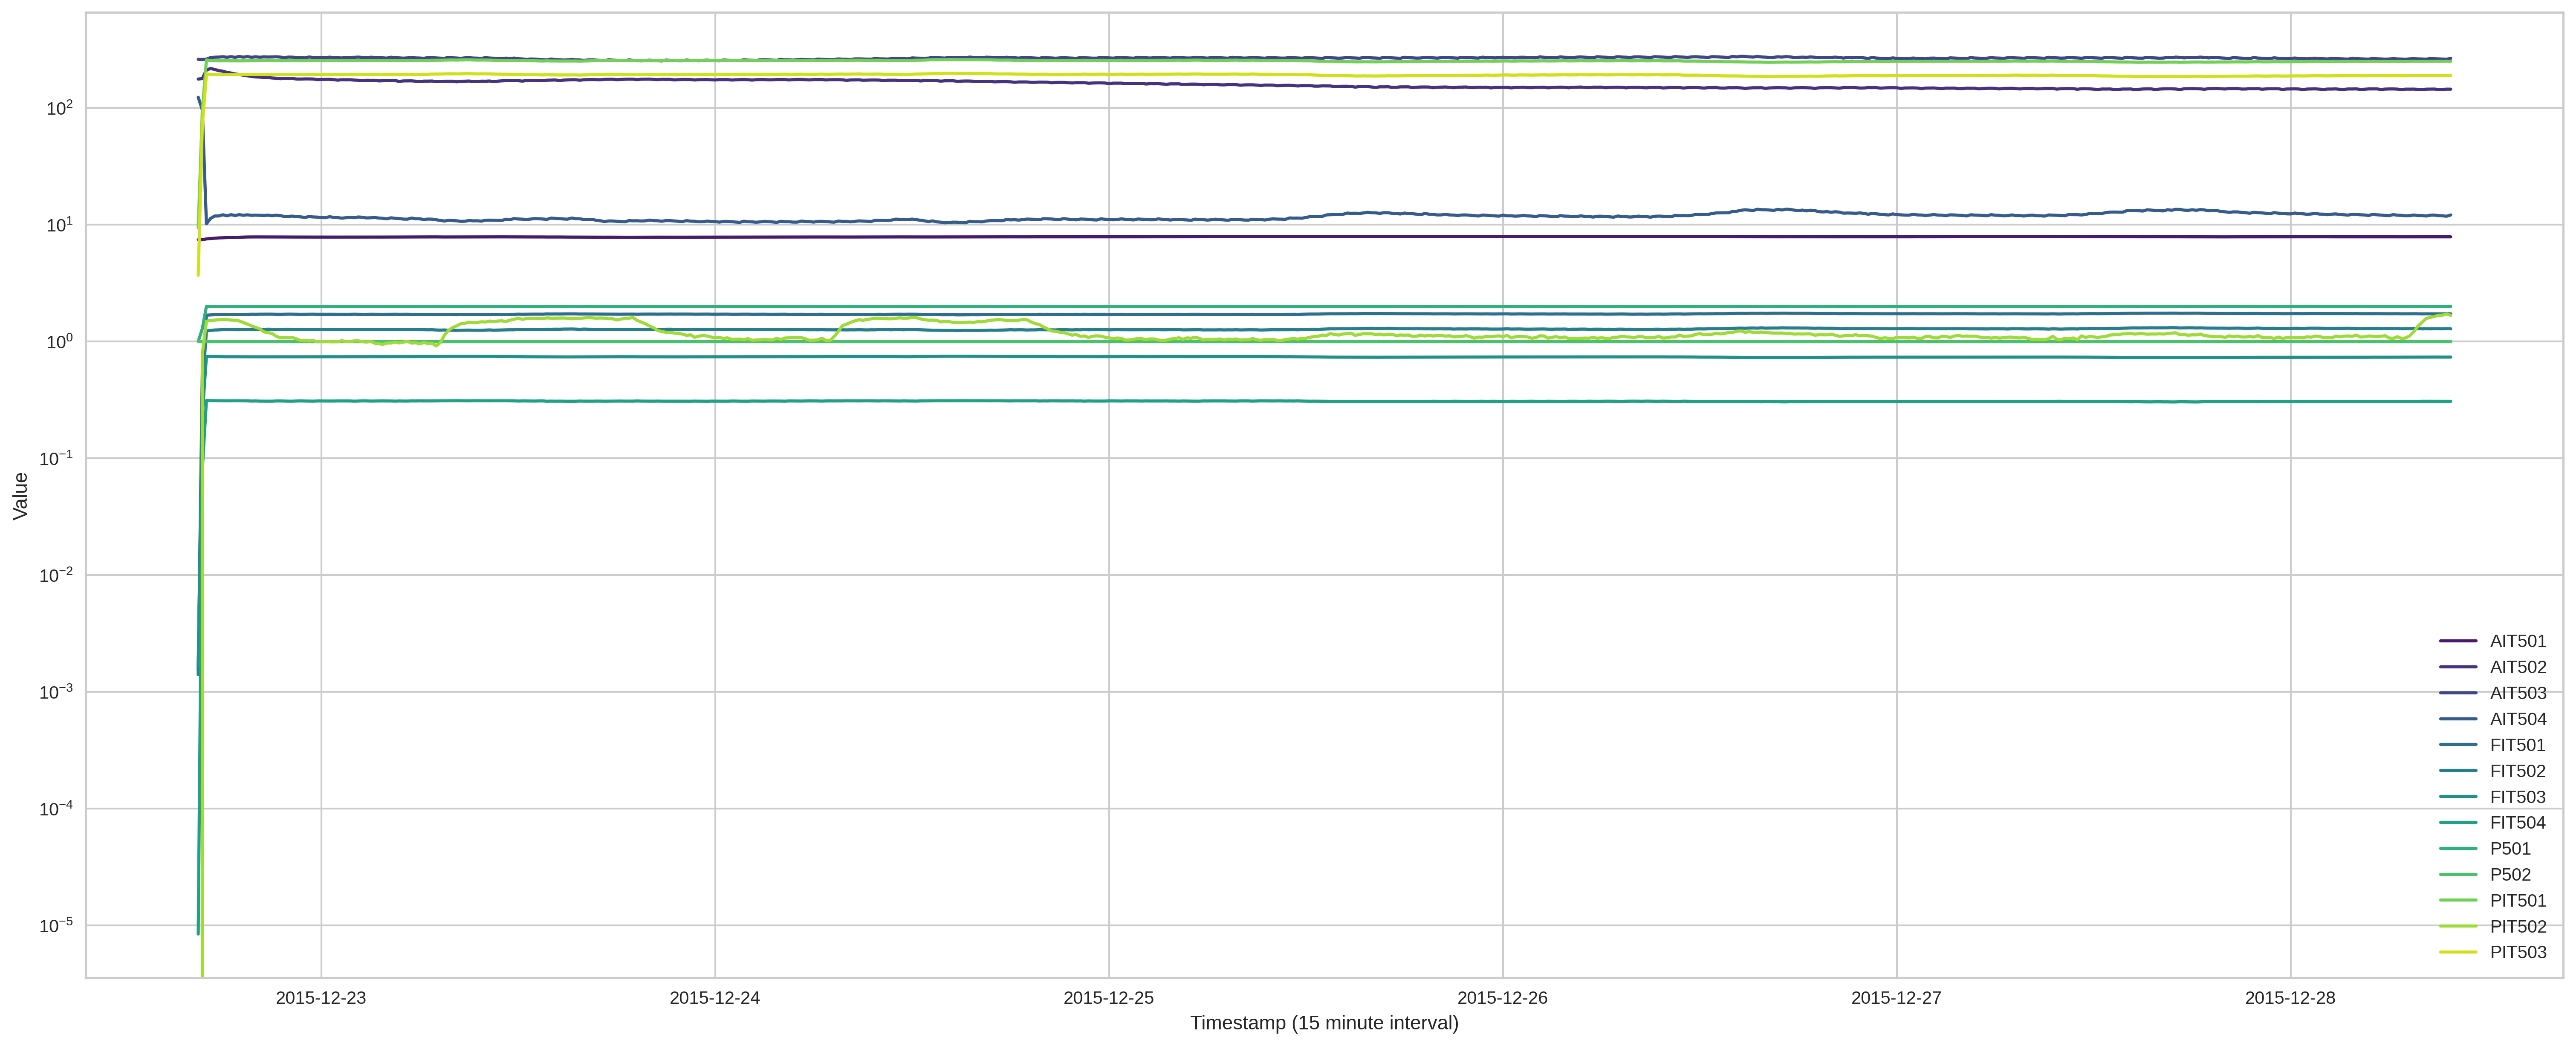

<IPython.core.display.Javascript object>

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10), dpi=300)
T=15
sample_df = normal_df[sub_system_P5].copy() #.loc["2015-12-26 10:00:00":"2015-12-26 11:00:00"]
value_vars = sample_df.columns.tolist()
sample_df.index = pd.to_datetime(sample_df.index)
resample_df = sample_df.resample(f"{T}Min").mean()
# resample_df = sample_df.rolling(T*60, min_periods=1).mean()

print(value_vars)
print(resample_df.head())
colors = list(mcolors.TABLEAU_COLORS.keys())[:len(value_vars)]

# for i, col in enumerate(resample_df.columns.tolist()):
#   print(f'creating plot for {col} with color: {colors[i][4:]}')
p=sns.lineplot(data = resample_df, palette='viridis', dashes=False)
p.set(yscale='log')
ax.legend(value_vars)
ax.set_xlabel(f"Timestamp ({T} minute interval)")
ax.set_ylabel('Value')

# plt.show()

In [ ]:
def getSubSystemMetaData(idx):
  return sub_systems[idx], num_cols[idx], cat_cols[idx], ignore_cols[idx]

def assertColumns(df, ss_cols, num_cols, cat_cols, ignore_cols):
  normal_df = df[ss_cols]
  print(f"len(normal_df.columns.tolist()): {len(normal_df.columns.tolist())}")
  print(f"len(num_cols): {len(num_cols)}")
  print(f"len(cat_cols): {len(cat_cols)}")
  assert len(normal_df.columns.tolist()) == len(num_cols) + len(cat_cols) + len(ignore_cols)

<IPython.core.display.Javascript object>

In [ ]:
def generateModels(df):
  for idx in range(6):
    ss_cols, num_cols, cat_cols, ignore_cols = getSubSystemMetaData(idx)    
    assertColumns(normal_df, ss_cols, num_cols, cat_cols, ignore_cols)
      
    # Set-up models
    setup_anom = setup(
        dfTrain,
        numeric_features=num_cols,
        categorical_features=cat_cols,
        ignore_features=ignore_cols,
        silent=True,
        normalize=True,
        verbose=True,
    )
    trainAndPersistModels(idx, listOfModelsBatch1 + listOfModelsBatch2, data_path, 0.05)

    

<IPython.core.display.Javascript object>

In [ ]:
def generateModel(df, idx):
  ss_cols, num_cols, cat_cols, ignore_cols = getSubSystemMetaData(idx)
  print(ss_cols)
  print(num_cols)
  print(cat_cols)
  print(ignore_cols)
  assertColumns(normal_df, ss_cols, num_cols, cat_cols, ignore_cols)
  dfTrain = df[list(set(ss_cols).difference(set(ignore_cols)))].copy()

  for nc in num_cols:
    dfTrain[nc] = dfTrain[nc].astype(np.float32)
  for cc in cat_cols:
    dfTrain[cc] = dfTrain[cc].astype('category')

  # print(f"Shape before sampling: {dfTrain.shape}")
  # dfTrain = dfTrain.sample(300000, random_state=42)  
    
  # print(f"Shape after sampling: {dfTrain.shape}")
  print(dfTrain.dtypes)

  df = pd.DataFrame()

  # Set-up models
  setup_anom = setup(
      dfTrain,
      numeric_features=num_cols,
      categorical_features=cat_cols,
      # ignore_features=ignore_cols,
      silent=True,
      normalize=True,
      verbose=True,
  )
  trainAndPersistModels(idx, listOfModelsBatch1 + listOfModelsBatch2, data_path, 0.05)


<IPython.core.display.Javascript object>

In [ ]:
# generateModel(normal_df, 2) #DONE NO NEED TO RUN THIS FURTHER! 

<IPython.core.display.Javascript object>

In [ ]:
#normal_df = normal_df.loc["2015-12-25 00:00:01":"2015-12-28 10:30:00"]
#generateModel(normal_df, 3) # ERRORED OUT

<IPython.core.display.Javascript object>

In [ ]:
# generateModel(normal_df, 4) #DONE NO NEED TO RUN THIS FURTHER! 

<IPython.core.display.Javascript object>

In [ ]:
# generateModel(normal_df, 5) #DONE NO NEED TO RUN THIS FURTHER! 

<IPython.core.display.Javascript object>

In [ ]:
### SUMIT: TODO: Here, pickup the attack data file --Done by Krishna ########
# Changed as on 13th Nov 2022
dfTest = pd.read_pickle(test_data_path_pickle)
display(dfTest.tail(10))
print("----------------------")
dfTest["Timestamp"] = pd.to_datetime(dfTest["Timestamp"])
# Above Line - It will save in "%Y-%m-%d %H:%M:%S format by default
dfTest["formatTimestamp"] = pd.to_datetime(dfTest["Timestamp"], format="%Y-%m-%d %H:%M:%S").dt.strftime("%Y-%m-%d %H:%M:%S")

print(dfTest.shape)
dfTest.head()
dfTest.tail(10)

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P202,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P401,P402,P403,P404,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
449909,2/1/2016 2:59:50 PM,2.633956,516.8018,2,2,1,168.0979,8.642528,301.8457,2.462051,2,2,1,2,1,2,1,20.39823,2.194792,975.5511,1,2,1,1,1,2,148.8032,145.6037,1.706340,955.3320,1,2,1,1,2,7.744360,139.2464,257.1136,14.8039,1.714560,1.273216,0.734885,0.308426,2,1,251.3779,0.945119,189.1182,0.0,1,1,1,Normal
449910,2/1/2016 2:59:51 PM,2.626909,516.9588,2,2,1,168.0979,8.642528,301.8457,2.460898,2,2,1,2,1,2,1,20.39823,2.194792,975.0705,1,2,1,1,1,2,148.8032,145.6037,1.707622,955.7549,1,2,1,1,2,7.744360,139.2464,257.1136,14.8039,1.715201,1.281286,0.734885,0.306569,2,1,251.3779,0.945119,189.1182,0.0,1,1,1,Normal
449911,2/1/2016 2:59:52 PM,2.616340,517.4691,2,2,1,168.0979,8.642528,301.9226,2.460770,2,2,1,2,1,2,1,20.39823,2.194792,974.8302,1,2,1,1,1,2,148.8032,145.6037,1.707878,955.9088,1,2,1,1,2,7.745001,139.2464,257.1136,14.8039,1.716483,1.287434,0.734885,0.306569,2,1,251.3779,0.945119,189.1182,0.0,1,1,1,Normal
449912,2/1/2016 2:59:53 PM,2.606091,518.1757,2,2,1,168.0979,8.639965,301.9226,2.459488,2,2,1,2,1,2,1,20.39823,2.196586,974.8302,1,2,1,1,1,2,148.8032,145.6037,1.707878,956.2164,1,2,1,1,2,7.749167,139.2464,257.1136,14.8039,1.716483,1.292430,0.734885,0.306569,2,1,251.3779,0.945119,189.1182,0.0,1,1,1,Normal
449913,2/1/2016 2:59:54 PM,2.586555,518.9607,2,2,1,168.0979,8.638683,301.9226,2.459488,2,2,1,2,1,2,1,20.39823,2.196586,974.6299,1,2,1,1,1,2,148.8032,145.6037,1.706340,956.4855,1,2,1,1,2,7.749167,139.2464,257.1136,14.8039,1.716483,1.300756,0.734885,0.306569,2,1,251.3779,0.865024,189.1182,0.0,1,1,1,Normal
449914,2/1/2016 2:59:55 PM,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,2,2,1,2,1,2,1,20.39823,2.196586,974.5498,1,2,1,1,1,2,148.8032,145.6037,1.705315,956.8701,1,2,1,1,2,7.745642,139.1182,257.1136,14.8039,1.716483,1.288971,0.734885,0.306569,2,1,251.1535,0.865024,189.0220,0.0,1,1,1,Normal
449915,2/1/2016 2:59:56 PM,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,2,2,1,2,1,2,1,20.39823,2.196586,974.5898,1,2,1,1,1,2,148.8032,145.6037,1.705315,957.1777,1,2,1,1,2,7.745642,139.1182,257.1136,14.8039,1.714560,1.272704,0.734885,0.306569,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,Normal
449916,2/1/2016 2:59:57 PM,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,2,2,1,2,1,2,1,20.33101,2.195561,974.2695,1,2,1,1,1,2,148.8032,145.5524,1.706212,957.2930,1,2,1,1,2,7.745642,139.1182,257.1136,14.8039,1.714560,1.269502,0.734885,0.306569,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,Normal
449917,2/1/2016 2:59:58 PM,2.521218,520.7271,2,2,1,168.0979,8.638683,301.9226,2.460129,2,2,1,2,1,2,1,20.29579,2.195561,974.2294,1,2,1,1,1,2,148.8032,145.5524,1.706212,957.6775,1,2,1,1,2,7.745642,139.1182,257.1136,14.8039,1.714560,1.263866,0.734885,0.307978,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,Normal
449918,2/1/2016 2:59:59 PM,2.501681,521.1196,2,2,1,168.0979,8.638683,301.9226,2.458206,2,2,1,2,1,2,1,20.28619,2.198379,974.4296,1,2,1,1,1,2,148.8032,145.5524,1.705315,957.7544,1,2,1,1,2,7.745642,139.1182,257.1136,14.8039,1.714560,1.272704,0.734885,0.308298,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,Normal


----------------------
(449919, 54)


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P202,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P401,P402,P403,P404,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack,formatTimestamp
449909,2016-02-01 14:59:50,2.633956,516.8018,2,2,1,168.0979,8.642528,301.8457,2.462051,2,2,1,2,1,2,1,20.39823,2.194792,975.5511,1,2,1,1,1,2,148.8032,145.6037,1.706340,955.3320,1,2,1,1,2,7.744360,139.2464,257.1136,14.8039,1.714560,1.273216,0.734885,0.308426,2,1,251.3779,0.945119,189.1182,0.0,1,1,1,Normal,2016-02-01 14:59:50
449910,2016-02-01 14:59:51,2.626909,516.9588,2,2,1,168.0979,8.642528,301.8457,2.460898,2,2,1,2,1,2,1,20.39823,2.194792,975.0705,1,2,1,1,1,2,148.8032,145.6037,1.707622,955.7549,1,2,1,1,2,7.744360,139.2464,257.1136,14.8039,1.715201,1.281286,0.734885,0.306569,2,1,251.3779,0.945119,189.1182,0.0,1,1,1,Normal,2016-02-01 14:59:51
449911,2016-02-01 14:59:52,2.616340,517.4691,2,2,1,168.0979,8.642528,301.9226,2.460770,2,2,1,2,1,2,1,20.39823,2.194792,974.8302,1,2,1,1,1,2,148.8032,145.6037,1.707878,955.9088,1,2,1,1,2,7.745001,139.2464,257.1136,14.8039,1.716483,1.287434,0.734885,0.306569,2,1,251.3779,0.945119,189.1182,0.0,1,1,1,Normal,2016-02-01 14:59:52
449912,2016-02-01 14:59:53,2.606091,518.1757,2,2,1,168.0979,8.639965,301.9226,2.459488,2,2,1,2,1,2,1,20.39823,2.196586,974.8302,1,2,1,1,1,2,148.8032,145.6037,1.707878,956.2164,1,2,1,1,2,7.749167,139.2464,257.1136,14.8039,1.716483,1.292430,0.734885,0.306569,2,1,251.3779,0.945119,189.1182,0.0,1,1,1,Normal,2016-02-01 14:59:53
449913,2016-02-01 14:59:54,2.586555,518.9607,2,2,1,168.0979,8.638683,301.9226,2.459488,2,2,1,2,1,2,1,20.39823,2.196586,974.6299,1,2,1,1,1,2,148.8032,145.6037,1.706340,956.4855,1,2,1,1,2,7.749167,139.2464,257.1136,14.8039,1.716483,1.300756,0.734885,0.306569,2,1,251.3779,0.865024,189.1182,0.0,1,1,1,Normal,2016-02-01 14:59:54
449914,2016-02-01 14:59:55,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,2,2,1,2,1,2,1,20.39823,2.196586,974.5498,1,2,1,1,1,2,148.8032,145.6037,1.705315,956.8701,1,2,1,1,2,7.745642,139.1182,257.1136,14.8039,1.716483,1.288971,0.734885,0.306569,2,1,251.1535,0.865024,189.0220,0.0,1,1,1,Normal,2016-02-01 14:59:55
449915,2016-02-01 14:59:56,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,2,2,1,2,1,2,1,20.39823,2.196586,974.5898,1,2,1,1,1,2,148.8032,145.6037,1.705315,957.1777,1,2,1,1,2,7.745642,139.1182,257.1136,14.8039,1.714560,1.272704,0.734885,0.306569,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,Normal,2016-02-01 14:59:56
449916,2016-02-01 14:59:57,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,2,2,1,2,1,2,1,20.33101,2.195561,974.2695,1,2,1,1,1,2,148.8032,145.5524,1.706212,957.2930,1,2,1,1,2,7.745642,139.1182,257.1136,14.8039,1.714560,1.269502,0.734885,0.306569,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,Normal,2016-02-01 14:59:57
449917,2016-02-01 14:59:58,2.521218,520.7271,2,2,1,168.0979,8.638683,301.9226,2.460129,2,2,1,2,1,2,1,20.29579,2.195561,974.2294,1,2,1,1,1,2,148.8032,145.5524,1.706212,957.6775,1,2,1,1,2,7.745642,139.1182,257.1136,14.8039,1.714560,1.263866,0.734885,0.307978,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,Normal,2016-02-01 14:59:58
449918,2016-02-01 14:59:59,2.501681,521.1196,2,2,1,168.0979,8.638683,301.9226,2.458206,2,2,1,2,1,2,1,20.28619,2.198379,974.4296,1,2,1,1,1,2,148.8032,145.5524,1.705315,957.7544,1,2,1,1,2,7.745642,139.1182,257.1136,14.8039,1.714560,1.272704,0.734885,0.308298,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,Normal,2016-02-01 14:59:59


<IPython.core.display.Javascript object>

In [ ]:
dfTest.set_index("formatTimestamp", inplace=True)
print(dfTest.shape)

(449919, 53)


<IPython.core.display.Javascript object>

In [ ]:
def plot_sub_system(df, df_name, idx, agg_window_min=15):
  numeric_features_df = df[num_cols[idx]].copy()
  cat_features_df = df[cat_cols[idx]].copy()

  numeric_vars = numeric_features_df.columns.tolist()
  cat_vars = cat_features_df.columns.tolist()

  numeric_features_df.index = pd.to_datetime(numeric_features_df.index)
  cat_features_df.index = pd.to_datetime(cat_features_df.index)

  numeric_aggregate_df = numeric_features_df.resample(f"{agg_window_min}Min").mean()
  cat_aggregate_df = cat_features_df.resample(f"{agg_window_min}Min").mean()

  print(f"numeric_vars: {numeric_vars}")
  print(f"cat_vars: {cat_vars}")
  # print(numeric_aggregate_df.head())
  colors = list(mcolors.TABLEAU_COLORS.keys())[:len(numeric_vars)]
  
  pa1 = sns.color_palette("hls", len(numeric_vars))
  pa2 = sns.color_palette("hls", len(cat_vars))

  fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(18, 6), dpi=300)
  sns.set_theme()

  num_plot=sns.lineplot(data = numeric_aggregate_df, palette=pa1, dashes=False, ax=ax1)
  num_plot.set(yscale='log')

  cat_plot=sns.lineplot(data = cat_aggregate_df, palette=pa2, dashes=False, ax=ax2)
  # cat_plot.set(yscale='log')

  ax1.set_title('Continuous Feature(s)')
  ax2.set_title('Categorical Feature(s)')

  ax1.legend(numeric_vars)
  ax2.legend(cat_vars)

  ax1.set_xlabel(f"Timestamp ({agg_window_min} minute interval)")
  ax1.set_ylabel('Mean Value (log scale)')

  ax2.set_xlabel(f"Timestamp ({agg_window_min} minute interval)")
  ax2.set_ylabel('Mean Value')

  plt.show()
  # plt.savefig(f'{plots_path}{df_name}_sub-system_{idx + 1}_{agg_window_min}_min.png')

<IPython.core.display.Javascript object>

numeric_vars: ['AIT402', 'AIT401', 'FIT401']
cat_vars: ['UV401', 'LIT401', 'P402']


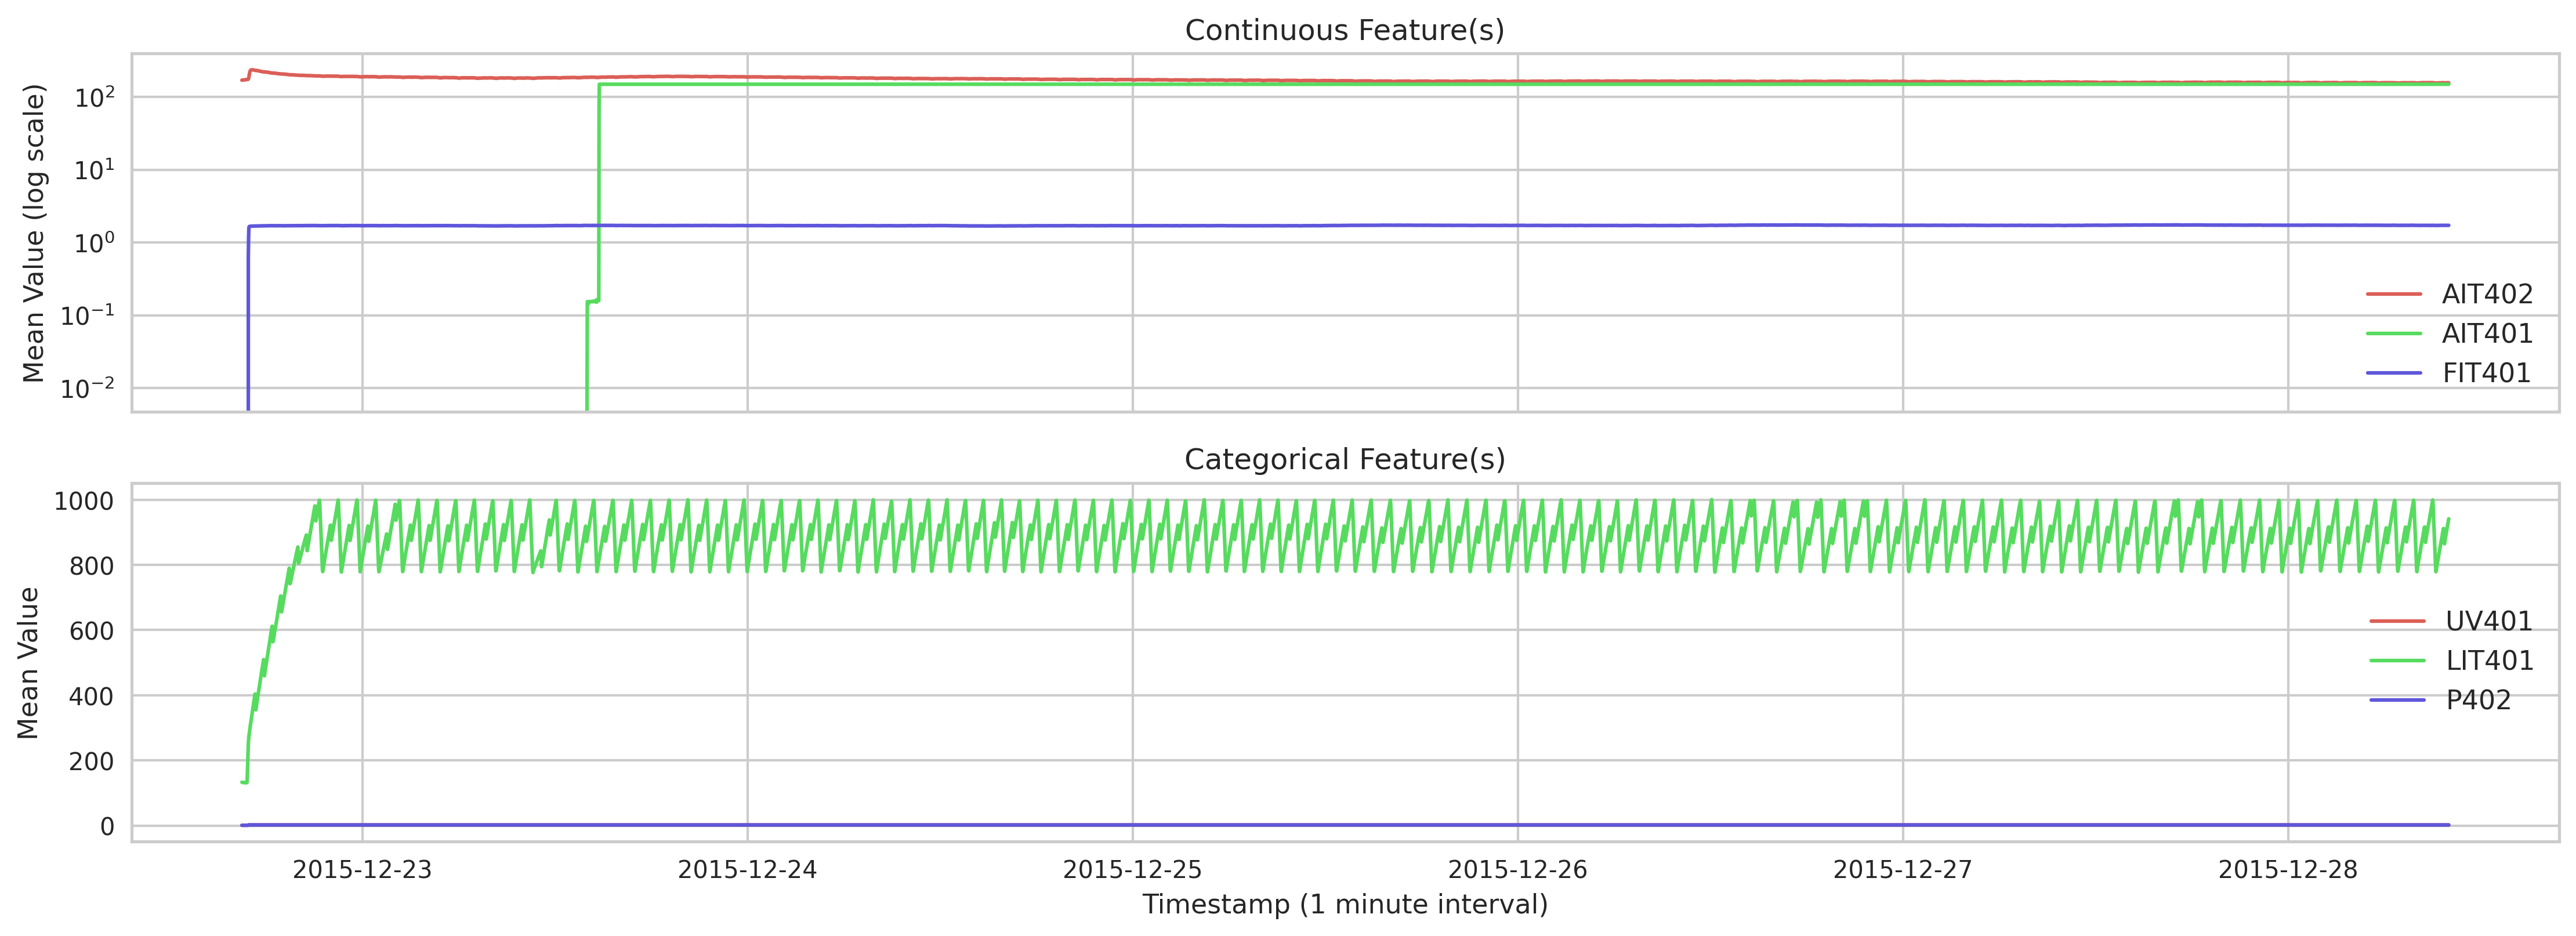

<IPython.core.display.Javascript object>

In [ ]:
plot_sub_system(normal_df, 'normal', 3, 1)

numeric_vars: ['AIT402', 'AIT401', 'FIT401']
cat_vars: ['UV401', 'LIT401', 'P402']


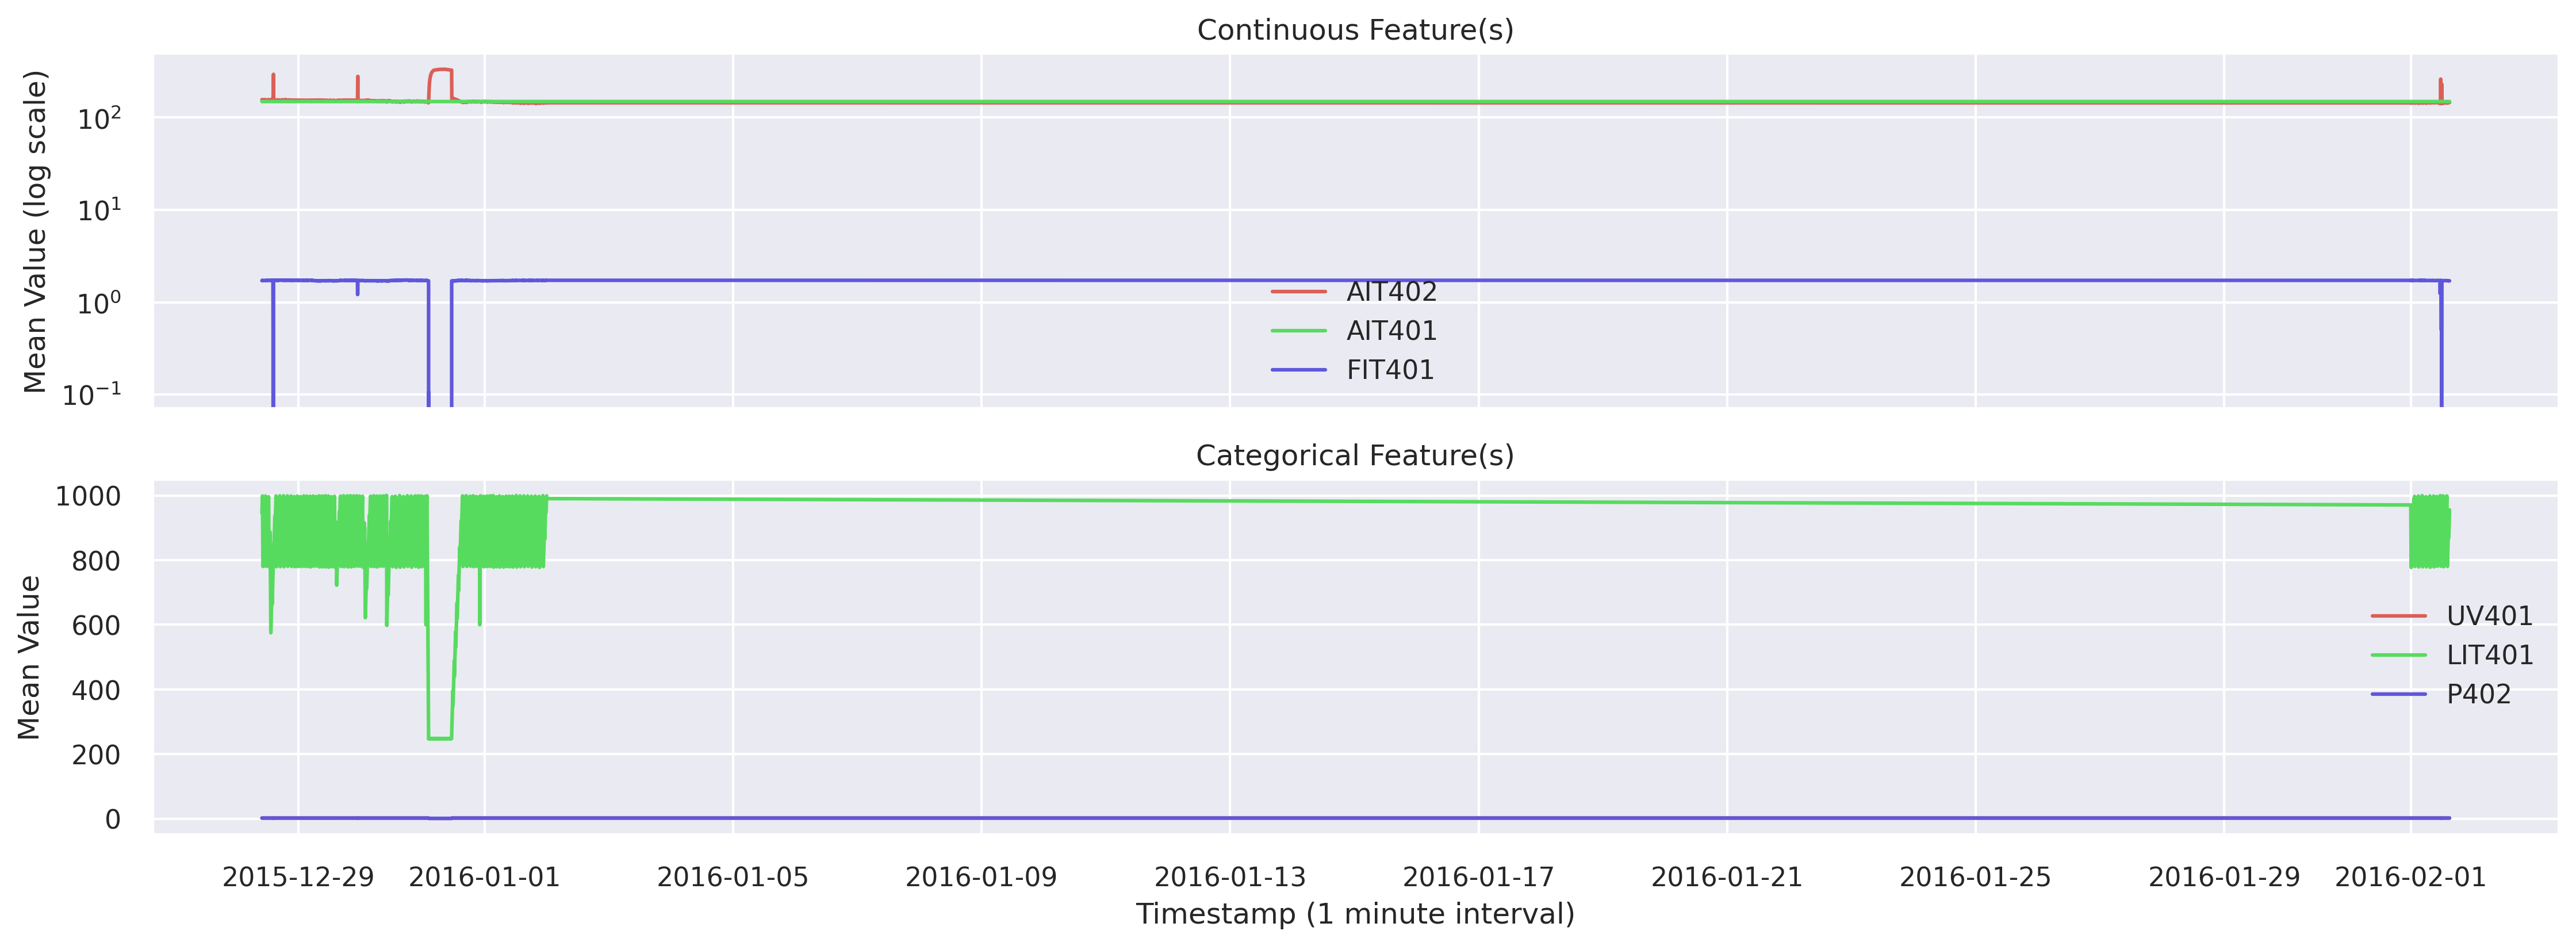

<IPython.core.display.Javascript object>

In [ ]:
plot_sub_system(dfTest, 'normal', 3, 1)

In [ ]:
display(dfTest.head())
display(dfTest.tail())

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P202,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P401,P402,P403,P404,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
formatTimestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-12-28 10:00:00,2015-12-28 10:00:00,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,2,1,1,2,1,2,1,19.74838,2.206835,956.1651,1,2,1,1,1,2,148.808,156.0882,1.713517,942.0662,1,2,1,1,2,7.878621,145.1166,264.5475,12.03538,1.723789,1.279621,0.735269,0.307786,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
2015-12-28 10:00:01,2015-12-28 10:00:01,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,2,1,1,2,1,2,1,19.74838,2.208244,956.1651,1,2,1,1,1,2,148.808,156.0882,1.715952,942.0277,1,2,1,1,2,7.878621,145.1166,264.5475,12.03538,1.723789,1.297554,0.735269,0.307786,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
2015-12-28 10:00:02,2015-12-28 10:00:02,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,2,1,1,2,1,2,1,19.69076,2.208628,956.4855,1,2,1,1,1,2,148.808,156.0882,1.715952,941.8739,1,2,1,1,2,7.878621,145.1166,264.5475,12.03538,1.723404,1.293967,0.735269,0.308619,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
2015-12-28 10:00:03,2015-12-28 10:00:03,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,2,1,1,2,1,2,1,19.69076,2.208628,956.8060,1,2,1,1,1,2,148.808,156.0882,1.714670,941.7970,1,2,1,1,2,7.878621,145.0141,264.5475,12.03538,1.723404,1.281158,0.735269,0.308619,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
2015-12-28 10:00:04,2015-12-28 10:00:04,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,2,1,1,2,1,2,1,19.69076,2.208628,957.0864,1,2,1,1,1,2,148.808,156.0882,1.714670,942.2200,1,2,1,1,2,7.878621,144.8859,264.5475,12.03538,1.723404,1.281158,0.735269,0.308619,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P202,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P401,P402,P403,P404,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
formatTimestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-02-01 14:59:55,2016-02-01 14:59:55,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,2,2,1,2,1,2,1,20.39823,2.196586,974.5498,1,2,1,1,1,2,148.8032,145.6037,1.705315,956.8701,1,2,1,1,2,7.745642,139.1182,257.1136,14.8039,1.716483,1.288971,0.734885,0.306569,2,1,251.1535,0.865024,189.0220,0.0,1,1,1,Normal
2016-02-01 14:59:56,2016-02-01 14:59:56,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,2,2,1,2,1,2,1,20.39823,2.196586,974.5898,1,2,1,1,1,2,148.8032,145.6037,1.705315,957.1777,1,2,1,1,2,7.745642,139.1182,257.1136,14.8039,1.714560,1.272704,0.734885,0.306569,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,Normal
2016-02-01 14:59:57,2016-02-01 14:59:57,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,2,2,1,2,1,2,1,20.33101,2.195561,974.2695,1,2,1,1,1,2,148.8032,145.5524,1.706212,957.2930,1,2,1,1,2,7.745642,139.1182,257.1136,14.8039,1.714560,1.269502,0.734885,0.306569,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,Normal
2016-02-01 14:59:58,2016-02-01 14:59:58,2.521218,520.7271,2,2,1,168.0979,8.638683,301.9226,2.460129,2,2,1,2,1,2,1,20.29579,2.195561,974.2294,1,2,1,1,1,2,148.8032,145.5524,1.706212,957.6775,1,2,1,1,2,7.745642,139.1182,257.1136,14.8039,1.714560,1.263866,0.734885,0.307978,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,Normal
2016-02-01 14:59:59,2016-02-01 14:59:59,2.501681,521.1196,2,2,1,168.0979,8.638683,301.9226,2.458206,2,2,1,2,1,2,1,20.28619,2.198379,974.4296,1,2,1,1,1,2,148.8032,145.5524,1.705315,957.7544,1,2,1,1,2,7.745642,139.1182,257.1136,14.8039,1.714560,1.272704,0.734885,0.308298,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,Normal


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# df1 = normal_df.copy()
# data = dfTrain.copy()
data_unseen = dfTest.copy()
# data.reset_index(drop=True, inplace=True)
# data_unseen.reset_index(drop=True, inplace=True)

# print("Data for Modeling: " + str(data.shape))
print("Unseen Data For Predictions: " + str(data_unseen.shape))

Unseen Data For Predictions: (449919, 53)


<IPython.core.display.Javascript object>

In [ ]:
print(num_cols)
print(cat_cols)
print(ignore_cols)
#print(data.columns)

[['FIT101', 'LIT101'], ['AIT202', 'AIT203', 'AIT201', 'FIT201'], ['FIT301', 'DPIT301', 'LIT301'], ['AIT402', 'AIT401', 'FIT401'], ['FIT503', 'AIT501', 'FIT504', 'AIT504', 'AIT503', 'FIT502', 'AIT502', 'PIT502', 'FIT501', 'PIT501', 'PIT503'], ['FIT601']]
[['MV101', 'P101'], ['P203', 'P205', 'MV201'], ['P302', 'P301', 'MV303', 'MV302', 'MV304', 'MV301'], ['UV401', 'LIT401', 'P402'], ['P501'], ['P602']]
[['P102'], ['P201', 'P202', 'P204', 'P206'], [], ['P401', 'P403', 'P404'], ['P502'], ['P601', 'P603']]


<IPython.core.display.Javascript object>

In [ ]:
data_unseen.head(10)

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P202,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P401,P402,P403,P404,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
formatTimestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-12-28 10:00:00,2015-12-28 10:00:00,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,2,1,1,2,1,2,1,19.74838,2.206835,956.1651,1,2,1,1,1,2,148.808,156.0882,1.713517,942.0662,1,2,1,1,2,7.878621,145.1166,264.5475,12.03538,1.723789,1.279621,0.735269,0.307786,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
2015-12-28 10:00:01,2015-12-28 10:00:01,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,2,1,1,2,1,2,1,19.74838,2.208244,956.1651,1,2,1,1,1,2,148.808,156.0882,1.715952,942.0277,1,2,1,1,2,7.878621,145.1166,264.5475,12.03538,1.723789,1.297554,0.735269,0.307786,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
2015-12-28 10:00:02,2015-12-28 10:00:02,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,2,1,1,2,1,2,1,19.69076,2.208628,956.4855,1,2,1,1,1,2,148.808,156.0882,1.715952,941.8739,1,2,1,1,2,7.878621,145.1166,264.5475,12.03538,1.723404,1.293967,0.735269,0.308619,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
2015-12-28 10:00:03,2015-12-28 10:00:03,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,2,1,1,2,1,2,1,19.69076,2.208628,956.8060,1,2,1,1,1,2,148.808,156.0882,1.714670,941.7970,1,2,1,1,2,7.878621,145.0141,264.5475,12.03538,1.723404,1.281158,0.735269,0.308619,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
2015-12-28 10:00:04,2015-12-28 10:00:04,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,2,1,1,2,1,2,1,19.69076,2.208628,957.0864,1,2,1,1,1,2,148.808,156.0882,1.714670,942.2200,1,2,1,1,2,7.878621,144.8859,264.5475,12.03538,1.723404,1.281158,0.735269,0.308619,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal
2015-12-28 10:00:05,2015-12-28 10:00:05,2.609294,523.8673,2,2,1,262.0161,8.394514,328.6337,2.444110,2,1,1,2,1,2,1,19.69076,2.207347,957.1664,1,2,1,1,1,2,148.808,155.9600,1.714670,942.6429,1,2,1,1,2,7.878621,144.8859,264.5475,12.03538,1.723404,1.272704,0.735269,0.308619,2,1,250.7530,1.649953,189.5027,0.000128,1,1,1,Normal
2015-12-28 10:00:06,2015-12-28 10:00:06,2.637158,524.1028,2,2,1,262.0161,8.394514,328.6337,2.444110,2,1,1,2,1,2,1,19.69076,2.210037,957.0062,1,2,1,1,1,2,148.808,155.9600,1.713004,942.7582,1,2,1,1,2,7.878621,144.8859,264.5475,12.03538,1.723404,1.270142,0.735269,0.308619,2,1,250.5928,1.649953,189.5027,0.000128,1,1,1,Normal
2015-12-28 10:00:07,2015-12-28 10:00:07,2.652211,524.2206,2,2,1,262.0161,8.394514,328.6337,2.441803,2,1,1,2,1,2,1,19.69076,2.210037,957.2866,1,2,1,1,1,2,148.808,155.9600,1.713004,943.1043,1,2,1,1,2,7.878621,144.8859,264.5475,12.03538,1.723404,1.262329,0.735269,0.308619,2,1,250.5928,1.649953,189.5027,0.000128,1,1,1,Normal
2015-12-28 10:00:08,2015-12-28 10:00:08,2.655735,524.4954,2,2,1,262.0161,8.394514,328.6337,2.441803,2,1,1,2,1,2,1,19.66195,2.210037,957.6071,1,2,1,1,1,2,148.808,155.9600,1.712620,943.3735,1,2,1,1,2,7.878621,144.8859,264.5475,12.03538,1.723404,1.270398,0.735269,0.308619,2,1,250.9132,1.649953,189.5027,0.000128,1,1,1,Normal


<IPython.core.display.Javascript object>

### Predict on Unseen Data

In [ ]:
# Changed as on 13th Nov 2022
#getPredictions(savedModelsDict, data_path, data_unseen, prediction_path)

<IPython.core.display.Javascript object>

In [ ]:
targetColsToPlot = ["AttackID", "Anomaly_ZScore"]

<IPython.core.display.Javascript object>

TODO (November 19 2022 - KK is working on it)
1. Split Predictions for each date
2. Ability to plot only specific plots or test plot
3. Change color scheme for Plotly


In [ ]:
#test
#plotModelByPlotly(newAttackDict[0], attackColorDict, targetColsToPlot, "histogram_P1_SWAT_Dec2015_Data_model", 
                      #"2015-12-28 10:29:14", "2015-12-28 12:04:10", isSavePlot=False,splitDir=prediction_path,
                      #plotDir=".",sliceCount=0,isFullData=False)
#plotModelByPlotly(attackDict, attackColorDict, targetCols, modelName, 
                      #timeSliceList, isSavePlot,splitDir,
                      #plotDir,sliceCount,isFullData)
# plotModelByPlotly(newAttackDict, attackColorDict, targetColsToPlot, "histogram_P1_SWAT_Dec2015_Data_model", 
#                       timeSliceList, isSavePlot=True,splitDir=prediction_path,
#                       plotDir=".",sliceCount=0,isFullData=False,isShowPlot=True)

<IPython.core.display.Javascript object>

In [ ]:
# Execution Block
# Plot all dates in a single plot
# Get All Plots    
    
getAllPlots(newAttackDict, attackColorDict, targetColsToPlot, savedPredictedModelsDict,timeSliceList ,isSavePlot=True, 
            splitDir=".",plotDir=".",sliceCount=0, isFullData =False,isShowPlot=False)

Processing iforest model
Processing iforest_P1_SWAT_Dec2015_Data_model modelName
Processing Finished for iforest_P1_SWAT_Dec2015_Data_model model
Processing iforest_P2_SWAT_Dec2015_Data_model modelName
Processing Finished for iforest_P2_SWAT_Dec2015_Data_model model
Processing iforest_P3_SWAT_Dec2015_Data_model modelName
Processing Finished for iforest_P3_SWAT_Dec2015_Data_model model
Processing iforest_P4_SWAT_Dec2015_Data_model modelName
Processing Finished for iforest_P4_SWAT_Dec2015_Data_model model
Processing iforest_P5_SWAT_Dec2015_Data_model modelName
Processing Finished for iforest_P5_SWAT_Dec2015_Data_model model
Processing iforest_P6_SWAT_Dec2015_Data_model modelName
Processing Finished for iforest_P6_SWAT_Dec2015_Data_model model
Processing Finished for iforest model
Processing mcd model
Processing mcd_P1_SWAT_Dec2015_Data_model modelName
Processing Finished for mcd_P1_SWAT_Dec2015_Data_model model
Processing mcd_P2_SWAT_Dec2015_Data_model modelName
Processing Finished for m

<IPython.core.display.Javascript object>

In [ ]:
#Test block
# dfE, dfS = getSummaryData(modelName="histogram_P1_SWAT_Dec2015_Data_model")
# print(dfE.shape, dfS.shape)
# display(dfE.head())
# display(dfS.head())

<IPython.core.display.Javascript object>

In [ ]:
# Execution Block
dfExpandedFinal, dfSummaryFinal = getMainData(savedPredictedModelsDict, isPersitResult=True)
print(dfExpandedFinal.shape)
display(dfExpandedFinal.head())
display(dfExpandedFinal.tail())

print(dfSummaryFinal.shape)
display(dfSummaryFinal.head())
display(dfSummaryFinal.tail())


Processing Prediction on Model --> iforest
Processing Prediction on Model Name --> iforest_P1_SWAT_Dec2015_Data_model
Processing Finished Prediction for Model Name --> iforest_P1_SWAT_Dec2015_Data_model
Processing Prediction on Model Name --> iforest_P2_SWAT_Dec2015_Data_model
Processing Finished Prediction for Model Name --> iforest_P2_SWAT_Dec2015_Data_model
Processing Prediction on Model Name --> iforest_P3_SWAT_Dec2015_Data_model
Processing Finished Prediction for Model Name --> iforest_P3_SWAT_Dec2015_Data_model
Processing Prediction on Model Name --> iforest_P4_SWAT_Dec2015_Data_model
Processing Finished Prediction for Model Name --> iforest_P4_SWAT_Dec2015_Data_model
Processing Prediction on Model Name --> iforest_P5_SWAT_Dec2015_Data_model
Processing Finished Prediction for Model Name --> iforest_P5_SWAT_Dec2015_Data_model
Processing Prediction on Model Name --> iforest_P6_SWAT_Dec2015_Data_model
Processing Finished Prediction for Model Name --> iforest_P6_SWAT_Dec2015_Data_mod

,Model_Name,AttackID,Total_Count_of_Actual_Attacks,Total_Count_of_Identified_Attacks,Identified_Attack(in %),Attack_Start_Time,Attack_End_Time,PropensityOfAttack (In Seconds)
0,iforest_P1_SWAT_Dec2015_Data_model,1,940,940,100.00,2015-12-28 10:29:14,2015-12-28 10:44:53,0.0
1,iforest_P1_SWAT_Dec2015_Data_model,2,443,419,94.58,2015-12-28 10:51:08,2015-12-28 10:58:30,0.0
2,iforest_P1_SWAT_Dec2015_Data_model,3,383,383,100.00,2015-12-28 11:22:00,2015-12-28 11:28:22,0.0
3,iforest_P1_SWAT_Dec2015_Data_model,4,390,363,93.08,2015-12-28 11:47:39,2015-12-28 11:54:08,2.0
4,iforest_P1_SWAT_Dec2015_Data_model,6,196,196,100.00,2015-12-28 12:00:55,2015-12-28 12:04:10,0.0


,Model_Name,AttackID,Total_Count_of_Actual_Attacks,Total_Count_of_Identified_Attacks,Identified_Attack(in %),Attack_Start_Time,Attack_End_Time,PropensityOfAttack (In Seconds)
26,svm_P2_SWAT_Dec2015_Data_model,32,601,601,100.0,2016-01-01 10:36:00,2016-01-01 10:46:00,0.0
27,svm_P2_SWAT_Dec2015_Data_model,33,444,444,100.0,2016-01-01 14:21:12,2016-01-01 14:28:35,0.0
28,svm_P2_SWAT_Dec2015_Data_model,34,101,101,100.0,2016-01-01 17:12:40,2016-01-01 17:14:20,0.0
29,svm_P2_SWAT_Dec2015_Data_model,35,481,481,100.0,2016-01-01 17:18:56,2016-01-01 17:26:56,0.0
30,svm_P2_SWAT_Dec2015_Data_model,36,540,540,100.0,2016-01-01 22:16:01,2016-01-01 22:25:00,0.0


(28, 5)


,Model_Name,Total_Count_of_Actual_Attacks,Total_Count_of_Identified_Attacks,Mean Of PropensityOfAttack (In Seconds),Identified_Attack(in %)
0,iforest_P1_SWAT_Dec2015_Data_model,50762,28415,1.16,55.98
0,iforest_P2_SWAT_Dec2015_Data_model,50762,46117,122.23,90.85
0,iforest_P3_SWAT_Dec2015_Data_model,50762,44823,58.19,88.30
0,iforest_P4_SWAT_Dec2015_Data_model,50762,32976,571.65,64.96
0,iforest_P5_SWAT_Dec2015_Data_model,50762,39916,173.06,78.63


,Model_Name,Total_Count_of_Actual_Attacks,Total_Count_of_Identified_Attacks,Mean Of PropensityOfAttack (In Seconds),Identified_Attack(in %)
0,knn_P3_SWAT_Dec2015_Data_model,50762,3181,396.68,6.27
0,knn_P5_SWAT_Dec2015_Data_model,50762,38671,380.71,76.18
0,knn_P6_SWAT_Dec2015_Data_model,50762,347,1543.48,0.68
0,svm_P1_SWAT_Dec2015_Data_model,50762,42296,67.19,83.32
0,svm_P2_SWAT_Dec2015_Data_model,50762,49700,20.45,97.91


<IPython.core.display.Javascript object>

In [ ]:
# Get All Statistics : A Datafram with Model Name , Attack ID , Attack Start Time,
# Attack End Time, Total Records in Attack period, Actual No. Of Attacks based on Z-score,
# Performace and Propensity

<IPython.core.display.Javascript object>

In [ ]:
# Execute Mail block and Calculate Summary table (mean score)

<IPython.core.display.Javascript object>

In [ ]:
dfSortedFrame = sortDataFrameByColumns(dfSummaryFinal, ["Identified_Attack(in %)"], ascending=False)
print(dfSortedFrame.shape)
dfSortedFrame.head(8)

(28, 5)


,Model_Name,Total_Count_of_Actual_Attacks,Total_Count_of_Identified_Attacks,Mean Of PropensityOfAttack (In Seconds),Identified_Attack(in %)
0,mcd_P3_SWAT_Dec2015_Data_model,50762,50393,0.00,99.27
0,svm_P2_SWAT_Dec2015_Data_model,50762,49700,20.45,97.91
0,histogram_P3_SWAT_Dec2015_Data_model,50762,49432,13.81,97.38
0,histogram_P1_SWAT_Dec2015_Data_model,50762,47732,24.45,94.03
0,mcd_P1_SWAT_Dec2015_Data_model,50762,47598,33.94,93.77
0,iforest_P2_SWAT_Dec2015_Data_model,50762,46117,122.23,90.85
0,histogram_P2_SWAT_Dec2015_Data_model,50762,44909,187.10,88.47
0,iforest_P3_SWAT_Dec2015_Data_model,50762,44823,58.19,88.30


<IPython.core.display.Javascript object>

In [ ]:
dfSortedFrame = sortDataFrameByColumns(dfSummaryFinal, ["Identified_Attack(in %)"], ascending=False)
print(dfSortedFrame.shape)
dfSortedFrame.head(20)

(28, 5)


,Model_Name,Total_Count_of_Actual_Attacks,Total_Count_of_Identified_Attacks,Mean Of PropensityOfAttack (In Seconds),Identified_Attack(in %)
0,mcd_P3_SWAT_Dec2015_Data_model,50762,50393,0.00,99.27
0,svm_P2_SWAT_Dec2015_Data_model,50762,49700,20.45,97.91
0,histogram_P3_SWAT_Dec2015_Data_model,50762,49432,13.81,97.38
0,histogram_P1_SWAT_Dec2015_Data_model,50762,47732,24.45,94.03
0,mcd_P1_SWAT_Dec2015_Data_model,50762,47598,33.94,93.77
0,iforest_P2_SWAT_Dec2015_Data_model,50762,46117,122.23,90.85
0,histogram_P2_SWAT_Dec2015_Data_model,50762,44909,187.10,88.47
0,iforest_P3_SWAT_Dec2015_Data_model,50762,44823,58.19,88.30
0,svm_P1_SWAT_Dec2015_Data_model,50762,42296,67.19,83.32
0,iforest_P5_SWAT_Dec2015_Data_model,50762,39916,173.06,78.63


<IPython.core.display.Javascript object>

In [ ]:
dfSortedFrame = sortDataFrameByColumns(dfSummaryFinal, ["Mean Of PropensityOfAttack (In Seconds)"], ascending=True)
print(dfSortedFrame.shape)
dfSortedFrame.head(8)

(28, 5)


,Model_Name,Total_Count_of_Actual_Attacks,Total_Count_of_Identified_Attacks,Mean Of PropensityOfAttack (In Seconds),Identified_Attack(in %)
0,mcd_P3_SWAT_Dec2015_Data_model,50762,50393,0.00,99.27
0,iforest_P1_SWAT_Dec2015_Data_model,50762,28415,1.16,55.98
0,histogram_P3_SWAT_Dec2015_Data_model,50762,49432,13.81,97.38
0,svm_P2_SWAT_Dec2015_Data_model,50762,49700,20.45,97.91
0,histogram_P1_SWAT_Dec2015_Data_model,50762,47732,24.45,94.03
0,mcd_P1_SWAT_Dec2015_Data_model,50762,47598,33.94,93.77
0,iforest_P3_SWAT_Dec2015_Data_model,50762,44823,58.19,88.30
0,svm_P1_SWAT_Dec2015_Data_model,50762,42296,67.19,83.32


<IPython.core.display.Javascript object>

In [ ]:
dfSortedFrame = sortDataFrameByColumns(dfExpandedFinal, ["Identified_Attack(in %)"], ascending=False)
print(dfSortedFrame.shape)
dfSortedFrame.head(8)

(868, 8)


,Model_Name,AttackID,Total_Count_of_Actual_Attacks,Total_Count_of_Identified_Attacks,Identified_Attack(in %),Attack_Start_Time,Attack_End_Time,PropensityOfAttack (In Seconds)
0,iforest_P1_SWAT_Dec2015_Data_model,1,940,940,100.0,2015-12-28 10:29:14,2015-12-28 10:44:53,0.0
7,histogram_P2_SWAT_Dec2015_Data_model,10,160,160,100.0,2015-12-28 14:16:20,2015-12-28 14:19:00,0.0
15,histogram_P2_SWAT_Dec2015_Data_model,21,721,721,100.0,2015-12-29 18:30:00,2015-12-29 18:42:00,0.0
14,histogram_P2_SWAT_Dec2015_Data_model,20,395,395,100.0,2015-12-29 18:15:43,2015-12-29 18:22:17,0.0
13,histogram_P2_SWAT_Dec2015_Data_model,19,259,259,100.0,2015-12-29 18:10:43,2015-12-29 18:15:01,0.0
12,histogram_P2_SWAT_Dec2015_Data_model,17,717,717,100.0,2015-12-29 14:38:12,2015-12-29 14:50:08,0.0
10,histogram_P2_SWAT_Dec2015_Data_model,14,431,431,100.0,2015-12-29 11:35:40,2015-12-29 11:42:50,0.0
9,histogram_P2_SWAT_Dec2015_Data_model,13,233,233,100.0,2015-12-29 11:11:25,2015-12-29 11:15:17,0.0


<IPython.core.display.Javascript object>

In [ ]:
#dfSortedFrame = sortDataFrameByColumns(dfExpandedFinal, ["Model_Name"], ascending=False)
print(dfSortedFrame.shape)
dfSortedFrame.head()

(868, 8)


,Model_Name,AttackID,Total_Count_of_Actual_Attacks,Total_Count_of_Identified_Attacks,Identified_Attack(in %),Attack_Start_Time,Attack_End_Time,PropensityOfAttack (In Seconds)
0,iforest_P1_SWAT_Dec2015_Data_model,1,940,940,100.0,2015-12-28 10:29:14,2015-12-28 10:44:53,0.0
7,histogram_P2_SWAT_Dec2015_Data_model,10,160,160,100.0,2015-12-28 14:16:20,2015-12-28 14:19:00,0.0
15,histogram_P2_SWAT_Dec2015_Data_model,21,721,721,100.0,2015-12-29 18:30:00,2015-12-29 18:42:00,0.0
14,histogram_P2_SWAT_Dec2015_Data_model,20,395,395,100.0,2015-12-29 18:15:43,2015-12-29 18:22:17,0.0
13,histogram_P2_SWAT_Dec2015_Data_model,19,259,259,100.0,2015-12-29 18:10:43,2015-12-29 18:15:01,0.0


<IPython.core.display.Javascript object>

In [ ]:
dfSortedFrame = sortDataFrameByColumns(dfExpandedFinal, ["PropensityOfAttack (In Seconds)"], ascending=True)
print(dfSortedFrame.shape)
dfSortedFrame.head(6)

(868, 8)


,Model_Name,AttackID,Total_Count_of_Actual_Attacks,Total_Count_of_Identified_Attacks,Identified_Attack(in %),Attack_Start_Time,Attack_End_Time,PropensityOfAttack (In Seconds)
0,iforest_P1_SWAT_Dec2015_Data_model,1,940,940,100.00,2015-12-28 10:29:14,2015-12-28 10:44:53,0.0
13,histogram_P2_SWAT_Dec2015_Data_model,19,259,259,100.00,2015-12-29 18:10:43,2015-12-29 18:15:01,0.0
12,histogram_P2_SWAT_Dec2015_Data_model,17,717,717,100.00,2015-12-29 14:38:12,2015-12-29 14:50:08,0.0
11,histogram_P2_SWAT_Dec2015_Data_model,16,276,273,98.91,2015-12-29 11:57:25,2015-12-29 12:02:00,0.0
10,histogram_P2_SWAT_Dec2015_Data_model,14,431,431,100.00,2015-12-29 11:35:40,2015-12-29 11:42:50,0.0
9,histogram_P2_SWAT_Dec2015_Data_model,13,233,233,100.00,2015-12-29 11:11:25,2015-12-29 11:15:17,0.0


<IPython.core.display.Javascript object>

In [ ]:
# Summary Frame without SubSystems
dfExpandedFinal['Model_Group'] = dfExpandedFinal['Model_Name'].apply(lambda x:x.split("_")[0])
print(dfExpandedFinal.shape)
dfExpandedFinal.head()

(868, 9)


,Model_Name,AttackID,Total_Count_of_Actual_Attacks,Total_Count_of_Identified_Attacks,Identified_Attack(in %),Attack_Start_Time,Attack_End_Time,PropensityOfAttack (In Seconds),Model_Group
0,iforest_P1_SWAT_Dec2015_Data_model,1,940,940,100.00,2015-12-28 10:29:14,2015-12-28 10:44:53,0.0,iforest
1,iforest_P1_SWAT_Dec2015_Data_model,2,443,419,94.58,2015-12-28 10:51:08,2015-12-28 10:58:30,0.0,iforest
2,iforest_P1_SWAT_Dec2015_Data_model,3,383,383,100.00,2015-12-28 11:22:00,2015-12-28 11:28:22,0.0,iforest
3,iforest_P1_SWAT_Dec2015_Data_model,4,390,363,93.08,2015-12-28 11:47:39,2015-12-28 11:54:08,2.0,iforest
4,iforest_P1_SWAT_Dec2015_Data_model,6,196,196,100.00,2015-12-28 12:00:55,2015-12-28 12:04:10,0.0,iforest


<IPython.core.display.Javascript object>

In [ ]:
dfExpandedFinal.to_csv(prediction_analysis_path+"dfExpandedModelResult_with_0.5.csv")

<IPython.core.display.Javascript object>

In [ ]:
dfSummaryModelGroup= getSummaryFrame(dfExpandedFinal, hasGroupColumn=True)
print(dfSummaryModelGroup.shape)
dfSummaryModelGroup.head(6)

(6, 5)


,Model_Group,Total_Count_of_Actual_Attacks,Total_Count_of_Identified_Attacks,Mean Of PropensityOfAttack (In Seconds),Identified_Attack(in %)
0,histogram,253810,176998,451.88,69.74
1,iforest,304572,194666,215.38,63.91
2,knn,253810,68174,784.25,26.86
3,lof,253810,32122,1423.04,12.66
4,mcd,253810,135462,488.98,53.37
5,svm,101524,91996,43.82,90.62


<IPython.core.display.Javascript object>

In [ ]:
dfSummaryModelGroup.to_csv(prediction_analysis_path+"dfSummaryModelGroup_with_0.5.csv")

<IPython.core.display.Javascript object>

In [ ]:
dfSortedFrame = sortDataFrameByColumns(dfSummaryModelGroup, ["Identified_Attack(in %)"], ascending=False)
print(dfSortedFrame.shape)
dfSortedFrame.head(6)

(6, 5)


,Model_Group,Total_Count_of_Actual_Attacks,Total_Count_of_Identified_Attacks,Mean Of PropensityOfAttack (In Seconds),Identified_Attack(in %)
5,svm,101524,91996,43.82,90.62
0,histogram,253810,176998,451.88,69.74
1,iforest,304572,194666,215.38,63.91
4,mcd,253810,135462,488.98,53.37
2,knn,253810,68174,784.25,26.86
3,lof,253810,32122,1423.04,12.66


<IPython.core.display.Javascript object>

In [ ]:
dfSortedFrame = sortDataFrameByColumns(dfSummaryModelGroup, ["Mean Of PropensityOfAttack (In Seconds)"], ascending=True)
print(dfSortedFrame.shape)
dfSortedFrame.head(6)

(6, 5)


,Model_Group,Total_Count_of_Actual_Attacks,Total_Count_of_Identified_Attacks,Mean Of PropensityOfAttack (In Seconds),Identified_Attack(in %)
5,svm,101524,91996,43.82,90.62
1,iforest,304572,194666,215.38,63.91
0,histogram,253810,176998,451.88,69.74
4,mcd,253810,135462,488.98,53.37
2,knn,253810,68174,784.25,26.86
3,lof,253810,32122,1423.04,12.66


<IPython.core.display.Javascript object>

In [ ]:
linePlotData = dfExpandedFinal[["AttackID","Identified_Attack(in %)", "Model_Group"]].groupby(["AttackID","Model_Group"]).agg({"Identified_Attack(in %)":"mean"}).reset_index()
linePlotData['Identified_Attack(in %)'] = np.round(linePlotData['Identified_Attack(in %)'],2)
options=['svm','iforest','histogram']
linePlotData = linePlotData[linePlotData['Model_Group'].isin(options) ]
print(linePlotData.shape)
display(linePlotData.head())



(93, 3)


,AttackID,Model_Group,Identified_Attack(in %)
0,1,histogram,45.09
1,1,iforest,65.74
5,1,svm,100.00
6,2,histogram,43.61
7,2,iforest,66.21


<IPython.core.display.Javascript object>

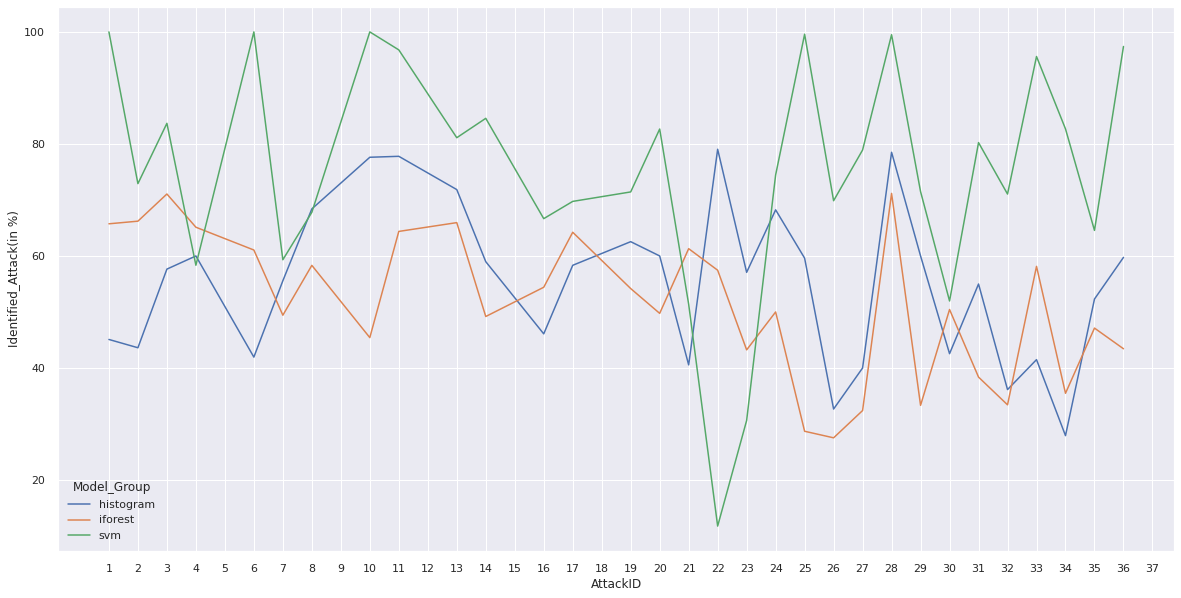

<IPython.core.display.Javascript object>

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})
g = sns.lineplot(data=linePlotData, x="AttackID", y="Identified_Attack(in %)", hue="Model_Group")
g.set_xticks(range(1,38))
g.set_xticklabels(range(1,38))

plt.savefig(prediction_plots_path +'Top3ModelsByIdentifiedAttacks.png')

<Figure size 1440x720 with 0 Axes>

<IPython.core.display.Javascript object>

In [ ]:
linePlotData = dfExpandedFinal[["AttackID","Identified_Attack(in %)", "Model_Group"]].groupby(["AttackID","Model_Group"]).agg({"Identified_Attack(in %)":"mean"}).reset_index()
linePlotData['Identified_Attack(in %)'] = np.round(linePlotData['Identified_Attack(in %)'],2)
options=['mcd','knn','lof']
linePlotData = linePlotData[linePlotData['Model_Group'].isin(options) ]
print(linePlotData.shape)
display(linePlotData.head())



(93, 3)


,AttackID,Model_Group,Identified_Attack(in %)
2,1,knn,60.00
3,1,lof,0.00
4,1,mcd,32.55
8,2,knn,41.13
9,2,lof,0.00


<IPython.core.display.Javascript object>

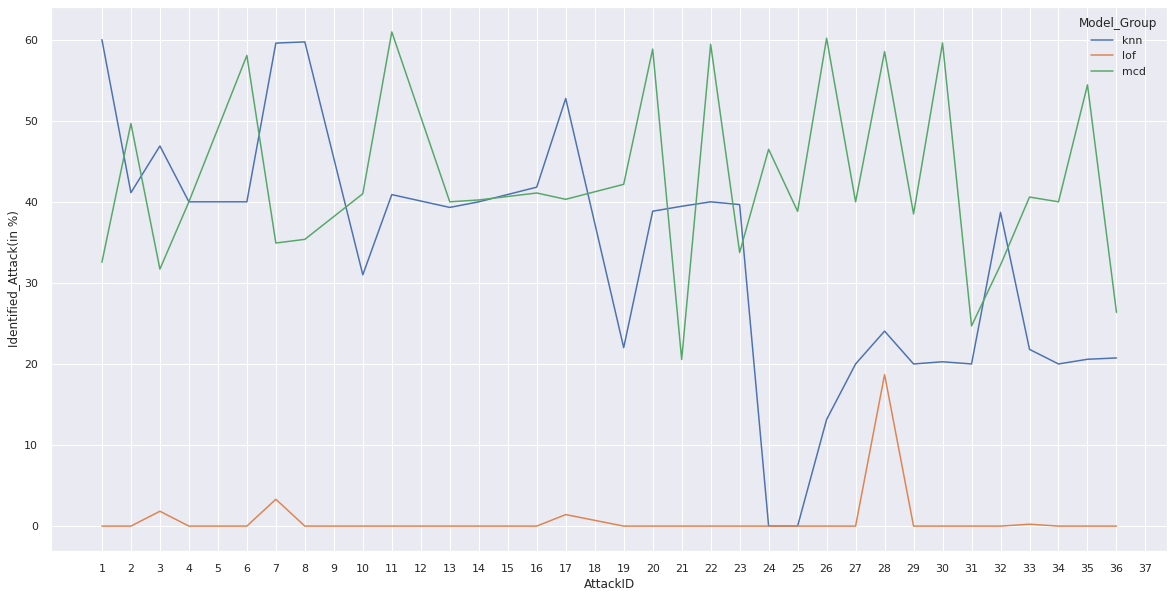

<IPython.core.display.Javascript object>

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})
g = sns.lineplot(data=linePlotData, x="AttackID", y="Identified_Attack(in %)", hue="Model_Group")
g.set_xticks(range(1,38))
g.set_xticklabels(range(1,38))

plt.savefig(prediction_plots_path +'Bottom3ModelsByIdentifiedAttacks.png')

<Figure size 1440x720 with 0 Axes>

<IPython.core.display.Javascript object>

In [ ]:
linePlotData = dfExpandedFinal[["AttackID","PropensityOfAttack (In Seconds)", "Model_Group"]].groupby(["AttackID","Model_Group"]).agg({"PropensityOfAttack (In Seconds)":"mean"}).reset_index()
linePlotData['PropensityOfAttack (In Seconds)'] = np.round(linePlotData['PropensityOfAttack (In Seconds)'],2)
options=['svm','iforest','histogram']
linePlotData = linePlotData[linePlotData['Model_Group'].isin(options) ]
print(linePlotData.shape)
display(linePlotData.head())

print(np.min(linePlotData['PropensityOfAttack (In Seconds)']))
print(np.max(linePlotData['PropensityOfAttack (In Seconds)']))


(93, 3)


,AttackID,Model_Group,PropensityOfAttack (In Seconds)
0,1,histogram,379.8
1,1,iforest,313.0
5,1,svm,0.0
6,2,histogram,169.2
7,2,iforest,87.0


0.0
7328.2


<IPython.core.display.Javascript object>

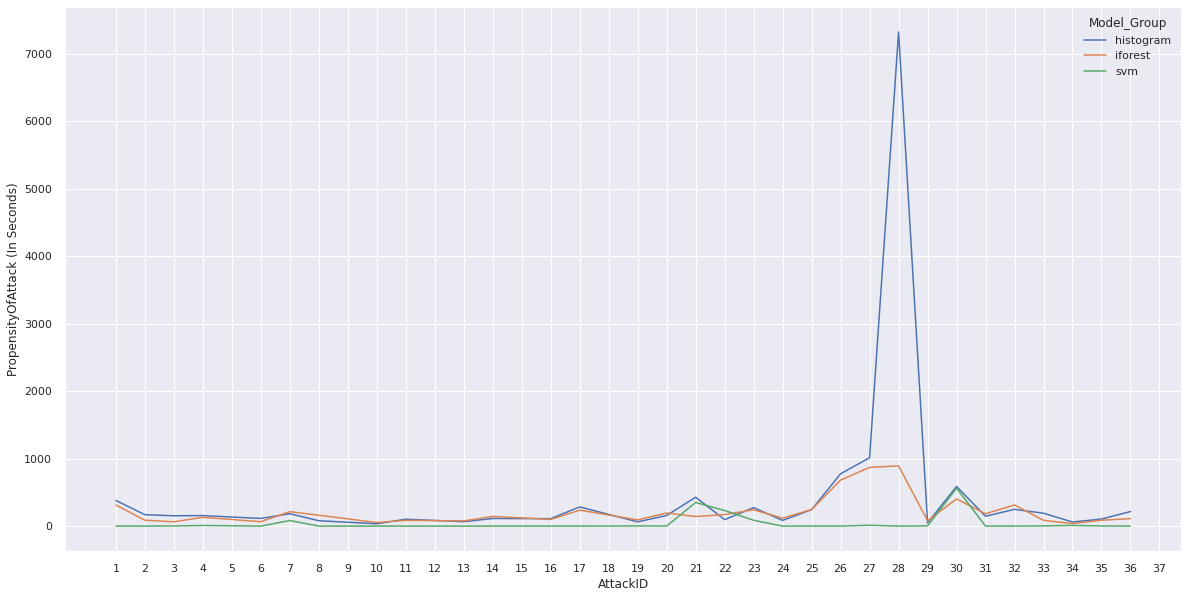

<IPython.core.display.Javascript object>

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})
g = sns.lineplot(data=linePlotData, x="AttackID", y="PropensityOfAttack (In Seconds)", hue="Model_Group")
g.set_xticks(range(1,38))
g.set_xticklabels(range(1,38))

plt.savefig(prediction_plots_path +'Top3ModelsByPropensity.png')

<Figure size 1440x720 with 0 Axes>

<IPython.core.display.Javascript object>

In [ ]:
linePlotData = dfExpandedFinal[["AttackID","PropensityOfAttack (In Seconds)", "Model_Group"]].groupby(["AttackID","Model_Group"]).agg({"PropensityOfAttack (In Seconds)":"mean"}).reset_index()
linePlotData['PropensityOfAttack (In Seconds)'] = np.round(linePlotData['PropensityOfAttack (In Seconds)'],2)
options=['mcd','knn','lof']
linePlotData = linePlotData[linePlotData['Model_Group'].isin(options) ]
print(linePlotData.shape)
display(linePlotData.head())


print(np.min(linePlotData['PropensityOfAttack (In Seconds)']))
print(np.max(linePlotData['PropensityOfAttack (In Seconds)']))


(93, 3)


,AttackID,Model_Group,PropensityOfAttack (In Seconds)
2,1,knn,375.6
3,1,lof,939.0
4,1,mcd,453.2
8,2,knn,193.6
9,2,lof,442.0


60.0
27815.4


<IPython.core.display.Javascript object>

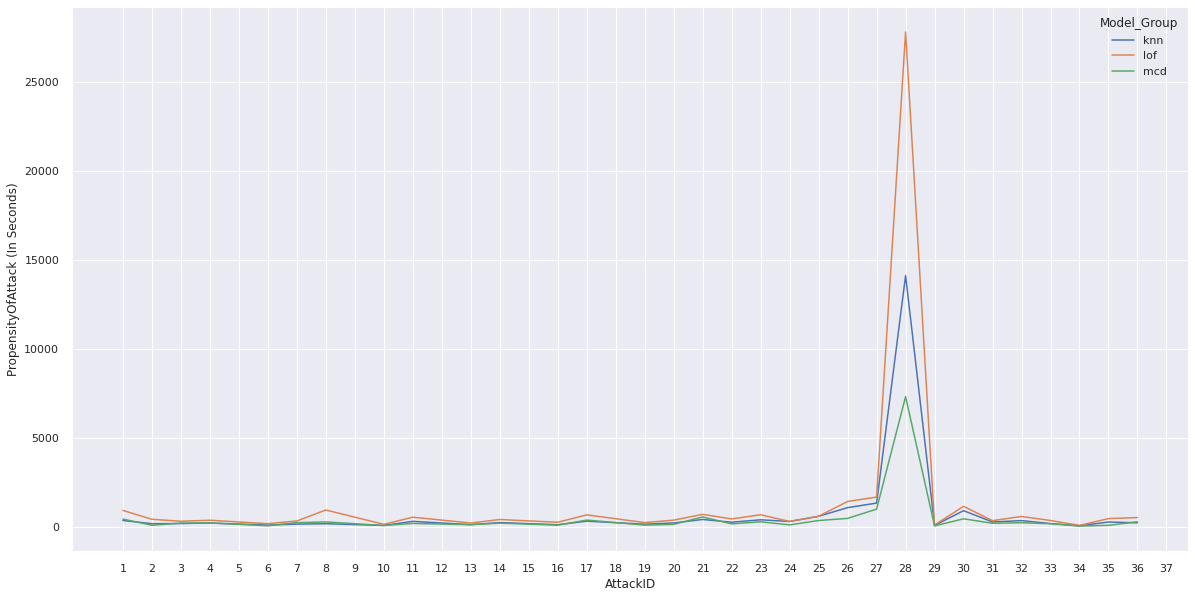

<IPython.core.display.Javascript object>

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})
g = sns.lineplot(data=linePlotData, x="AttackID", y="PropensityOfAttack (In Seconds)", hue="Model_Group")

g.set_xticks(range(1,38))
g.set_xticklabels(range(1,38))

plt.savefig(prediction_plots_path +'Bottom3ModelsByPropensity.png')

<Figure size 1440x720 with 0 Axes>

<IPython.core.display.Javascript object>